In [42]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import random

from PursueEvade import *

def p_from_Q(Q,tau):
    # make negative for stability
    aux = np.exp((Q-max(Q))*tau)
    return aux/sum(aux)

4


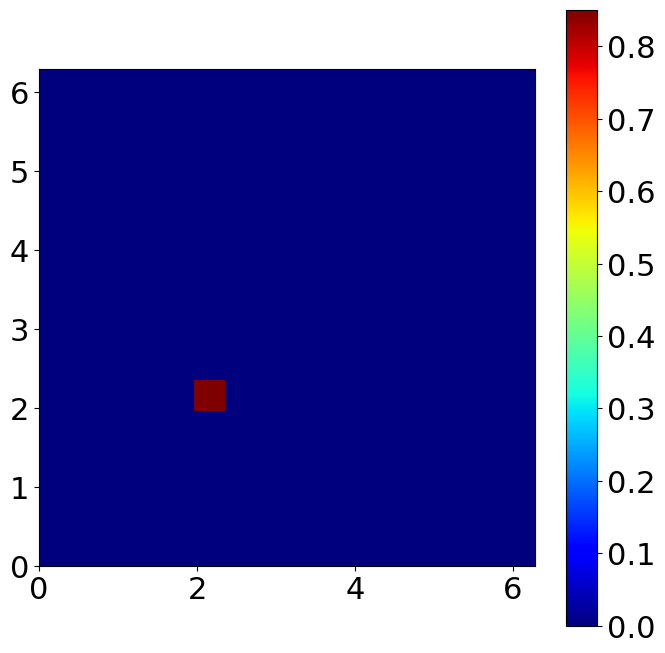

In [70]:
# make a tree for Q with 3 actions per coordinate
#
class Q_node:
    def __init__(self, parent=None, i=None, j=None):
        self.parent = parent
        self.i = i
        self.j = j
        self.depth = parent.depth+1
        if self.parent.values is None:
            self.values = np.zeros(3)
        else:
            self.values = self.parent.values.copy()
        
    def mean(self):
        return self.values @ np.arange(-1,2)
    
    # just return self here
    def node_from_coord(self,x,y,width=2*np.pi):
        return self

# index by x and y binary expansion
#             i/x
#          0       1
#       0    1   0   1
#      |---------------|
#     1|   |   |   |   |
#   1  |---+---+---+---|
#     0|   |   |   |   |
# j/y  |---+---+---+---|
#     1|   |   |   |   |
#   0  |---+---+---+---|
#     1|   |   |   |   |
#      |---------------|
class Bin_Tree:
    def __init__(self, init_depth=6, parent=None, i=None, j=None, values=None, max_depth=8):
        self.parent = parent
        self.i = i
        self.j = j
        
        # if there is a parent obtain this information from it
        if self.parent is None:
            self.max_depth = max_depth
            self.depth = 0 # root has depth zero
            self.values = None 
        else:
            self.max_depth = self.parent.max_depth
            self.depth = self.parent.depth+1
            if values is None:
                self.values = self.parent.values
            else:
                self.values = values
        
        # if one layer left or reaching max depth
        if init_depth == 1 or self.depth >= (self.max_depth-1):
            self.children = np.array([[Q_node(self,0,0), Q_node(self,0,1)], 
                                      [Q_node(self,1,0), Q_node(self,1,1)]])
        elif init_depth > 1:
            self.children = np.array([[Bin_Tree(init_depth-1,self,0,0), Bin_Tree(init_depth-1,self,0,1)],  
                                      [Bin_Tree(init_depth-1,self,1,0), Bin_Tree(init_depth-1,self,1,1)]])
        else:
            print('error: invalid depth data')
        
    # obtain leaf node that covers (x,y)
    def node_from_coord(self,x,y,width=2*np.pi):
        x=x/width
        y=y/width
        i = (x>0.5)*1
        j = (y>0.5)*1
        return self.children[i,j].node_from_coord(2*x-i,2*y-j,width=1)
    
    # refine a leaf node
    def refine(self,x,y,depth,width=2*np.pi):
        node = self.node_from_coord(x,y,width)
        # can't refine
        if node.depth >= self.max_depth:
            return
        else:
            node.parent.children[node.i,node.j] = Bin_Tree(depth, node.parent, node.i, node.j, values=node.values)
            del node
    
    # depict area with given refinement
    def draw(self, depth=6, width=2*np.pi, tau=1):
        plt.subplots(figsize=(8,8))
        depth = int(depth) # got make sure
        N = 2**depth
        M = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                x = 2**(-depth-1) + i*2**(-depth)
                y = 2**(-depth-1) + j*2**(-depth)
                p = p_from_Q(self.node_from_coord(x,y,width=1).values,tau)
                M[i,j] = p @ np.arange(-1,2)
        plt.imshow(M.T,cmap='jet',origin='lower',extent=[0,width,0,width])
        
        
            
# to see data structure
Example = Bin_Tree(2)

# node to increase resolution
# can only do two new layers - limit depth 3
Example.refine(2,2,2)
# change values to make it visible
Example.node_from_coord(2,2).values = np.arange(3)*2

print(Example.node_from_coord(2,2).mean())

# plot
Example.draw(6)
plt.colorbar()
# plt.plot([0,2*np.pi],[0,2*np.pi],'k')
del Example

In [34]:
depth, max_depth = 4,8
Q_tree = Bin_Tree(depth,max_depth=max_depth)
N = 2**depth
Temp = 10
TPer = .2
Tmax = 10
dt = 1e-3
eps = 5e-2
ue = lambda t,r1,r2,x1,x2: 0
umax = 3

# y_data = np.array([2*np.pi*(2**(-depth-1) + i*2**(-depth)) for i in range(2**depth)])
# x_data = np.arcsin(0.6*np.sin(y_data)) % (2*np.pi)

# for i,y in enumerate(y_data):
#     x = x_data[i]
#     Q_tree2.refine(x,y,depth=2)
#     x = (x_data[i] + 2*np.pi/N) % (2*np.pi)
#     Q_tree2.refine(x,y,depth=2)
#     x = (x_data[i] - 2*np.pi/N) % (2*np.pi)
#     Q_tree2.refine(x,y,depth=2)

# Q_tree2.node_from_coord(.1,.1,width=1).values=np.arange(3)
# #     print(Q_tree2.node_from_coord(x0,y).depth)
# #     print(x0,y)


# Q_tree2.draw(8)
# plt.scatter(x_data% (2*np.pi),y_data,marker='x',s=200)
# plt.colorbar()

In [71]:
depth = 2
Q_tree = Bin_Tree(depth,max_depth=8)
N = 2**depth
# constant parameters
Tmax = 10
dt = 1e-3
eps = 5e-2
ue = lambda t,r1,r2,x1,x2: 0
umax = 3

# initial depiction
# Q_tree.draw(6)
# plt.colorbar()
# plt.show()
# plt.savefig('untrained.pdf')

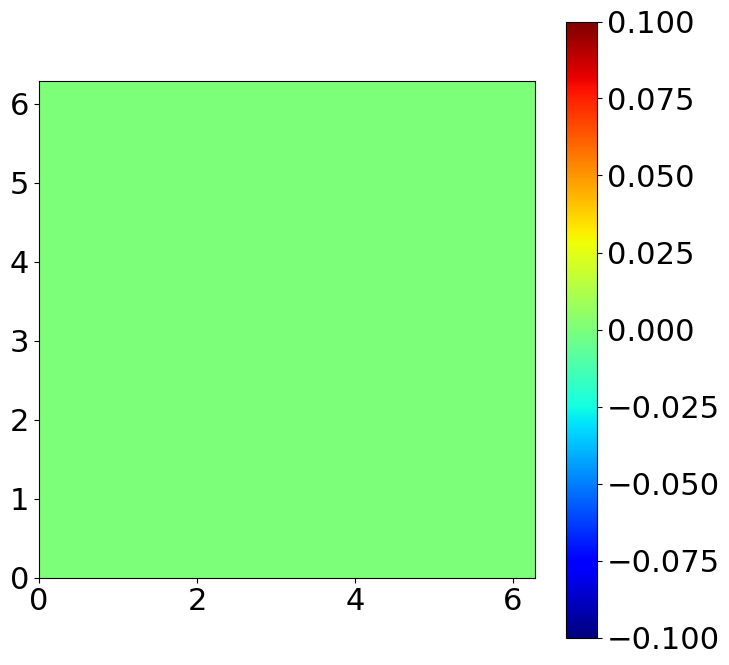

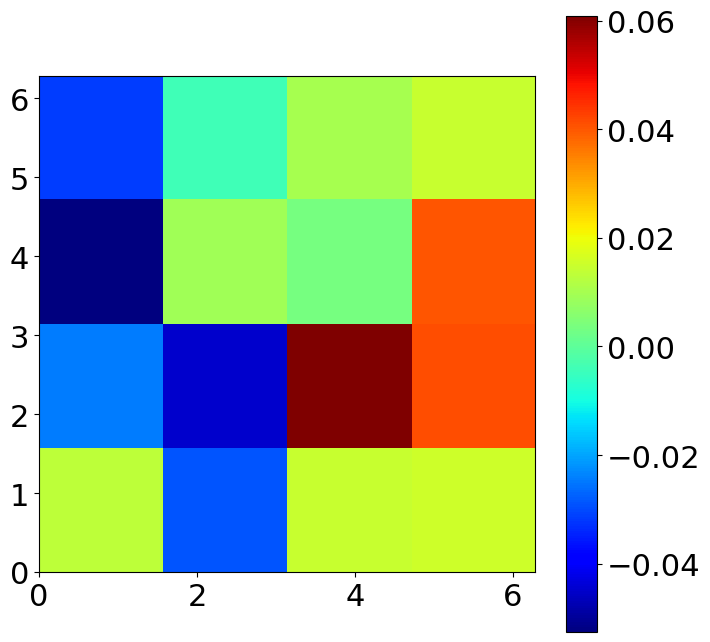

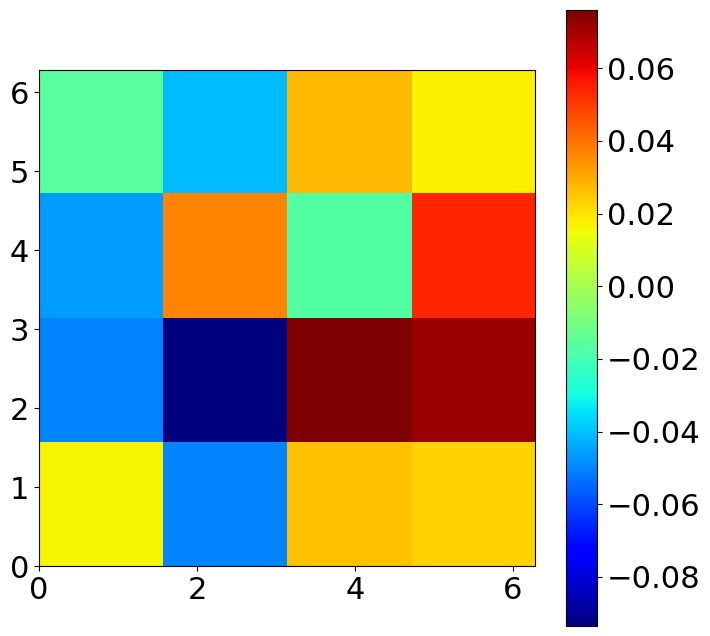

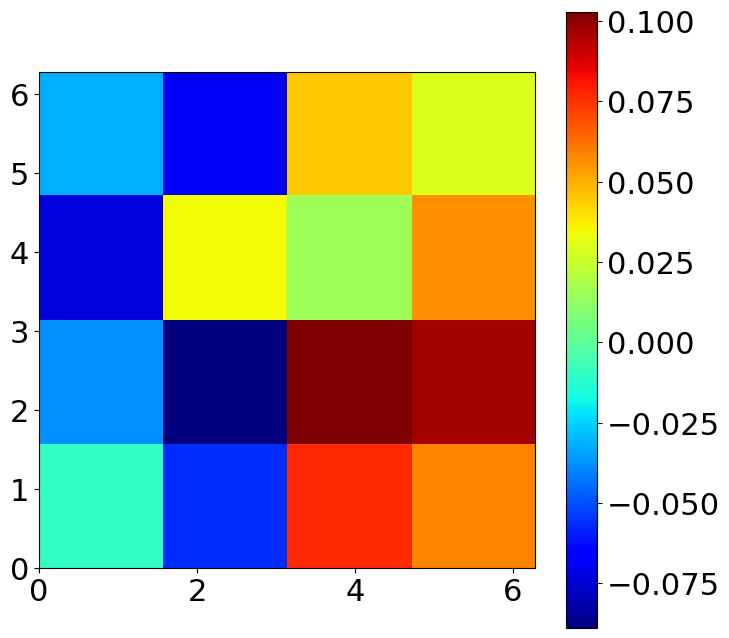

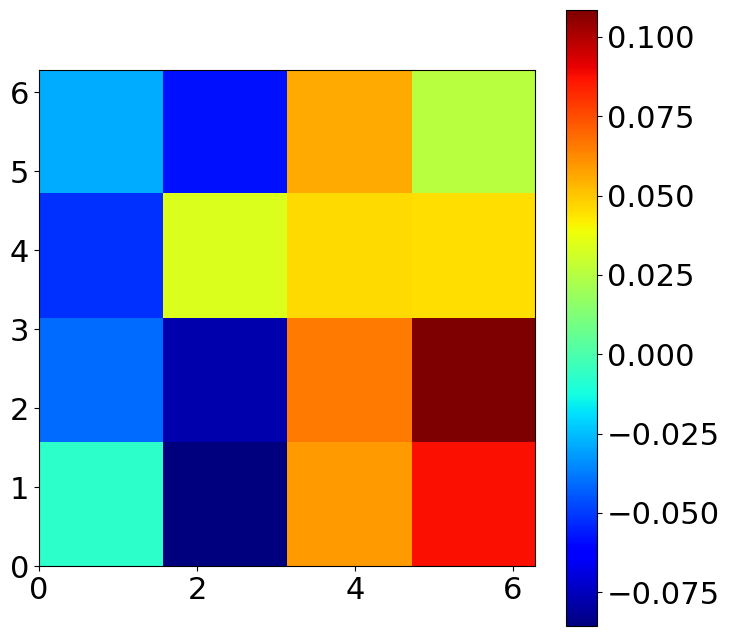

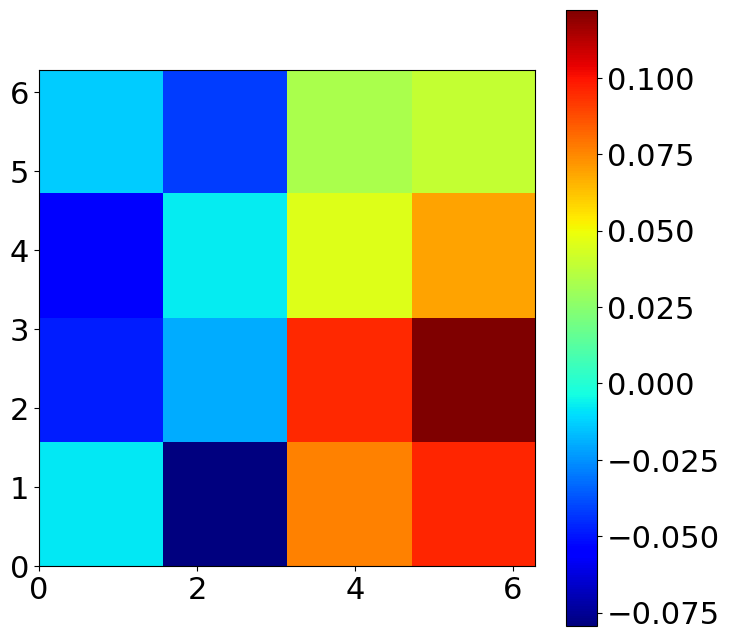

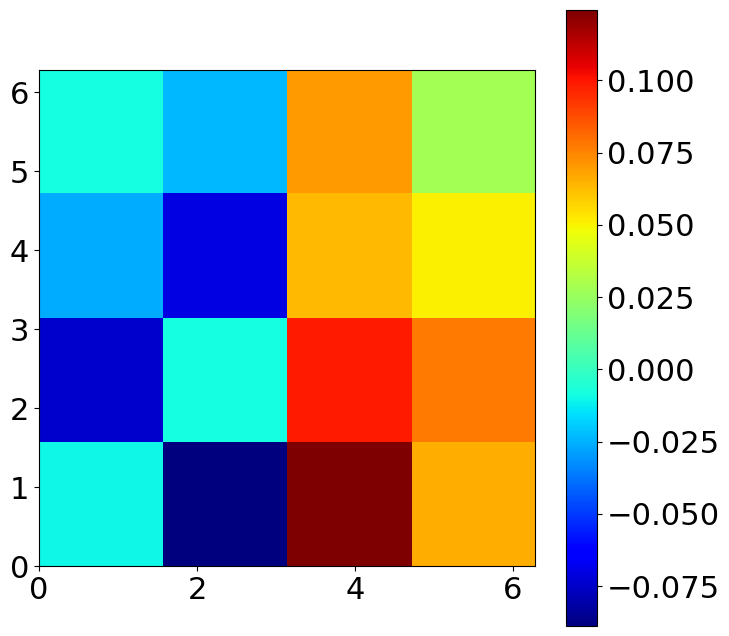

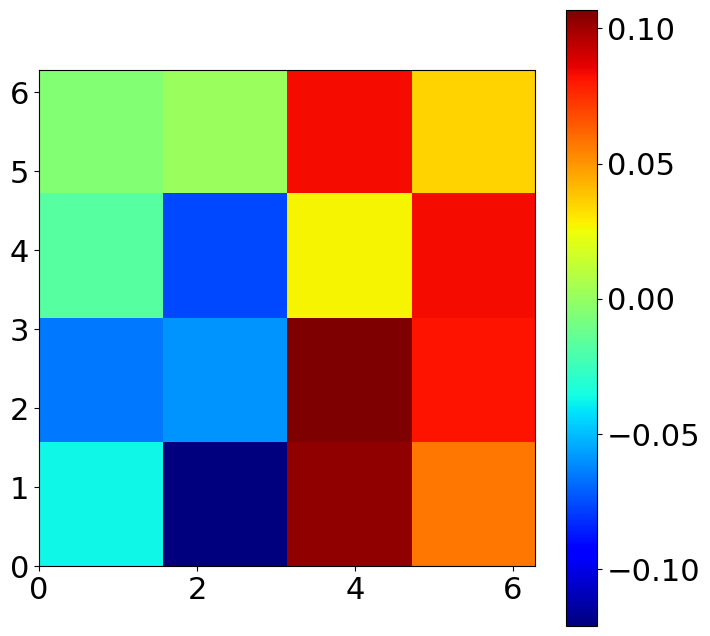

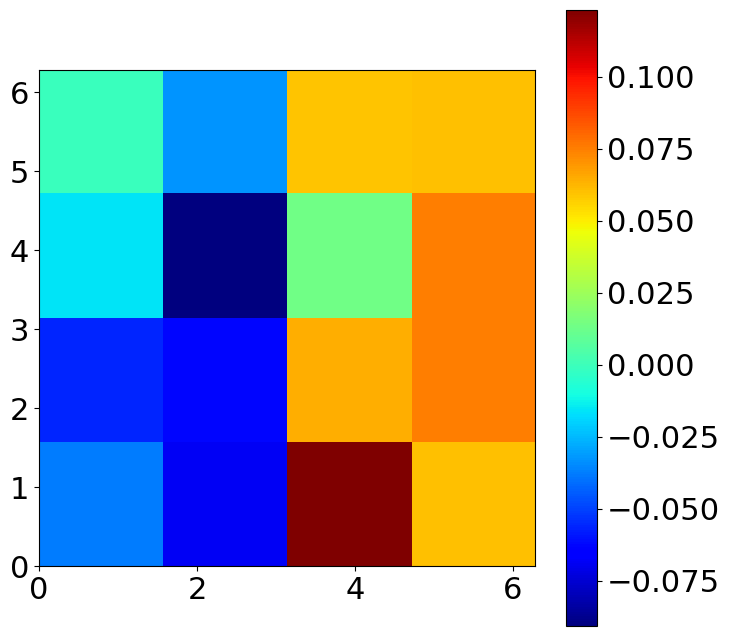

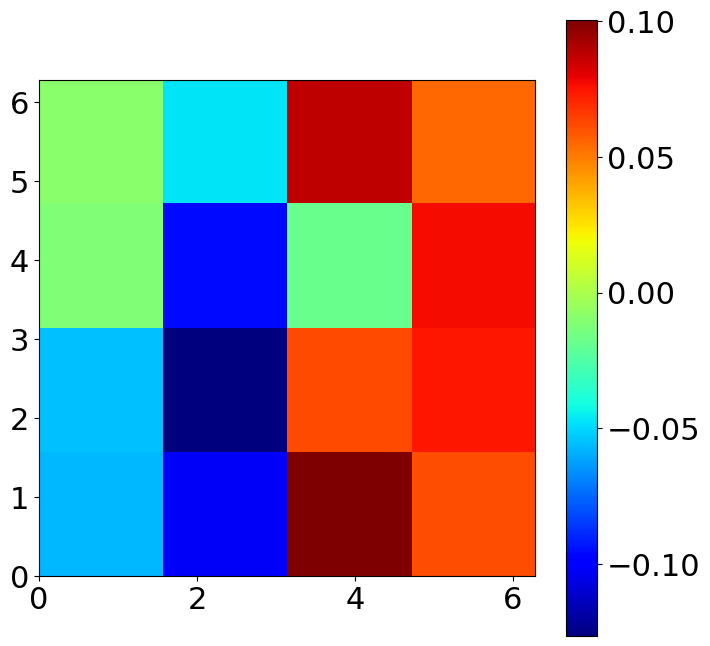

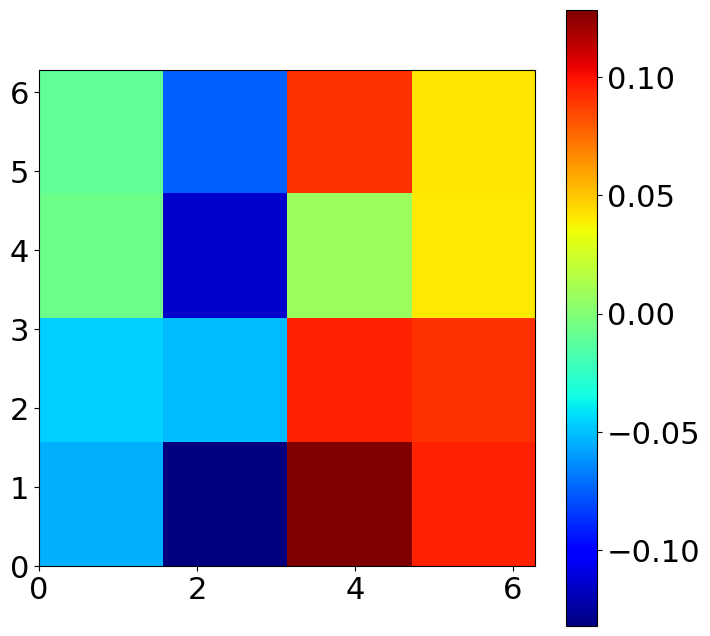

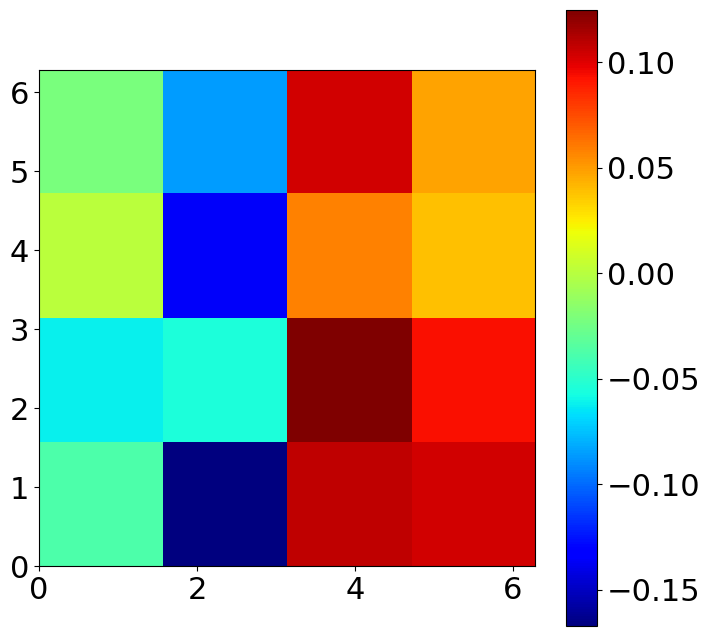

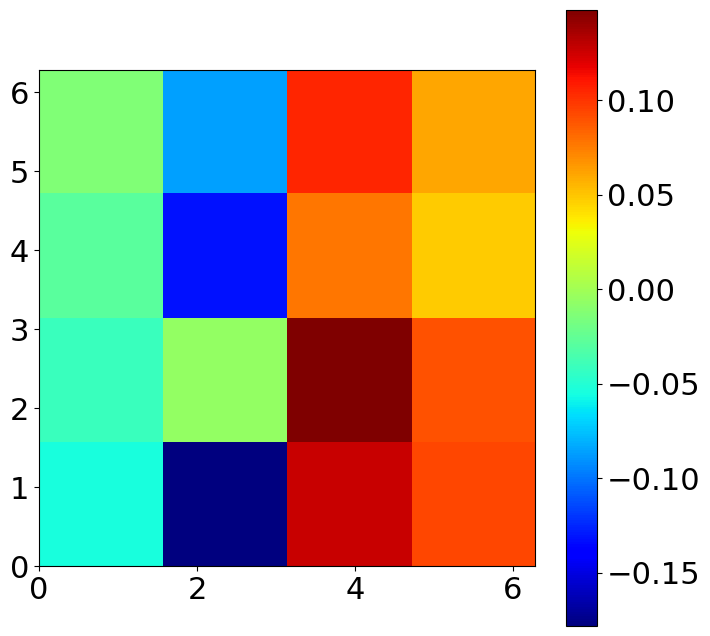

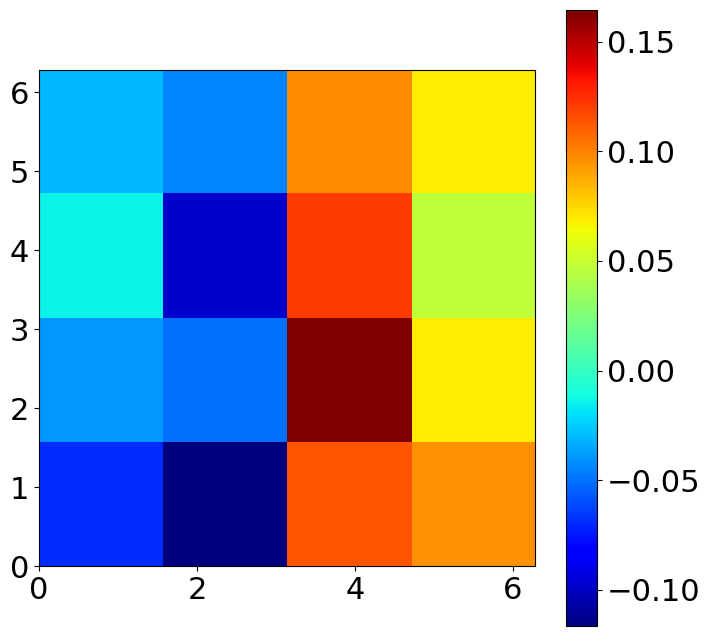

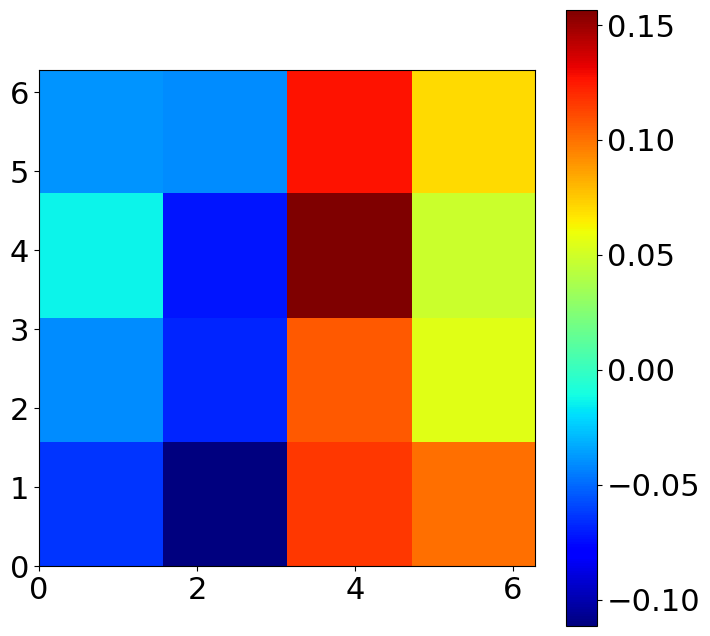

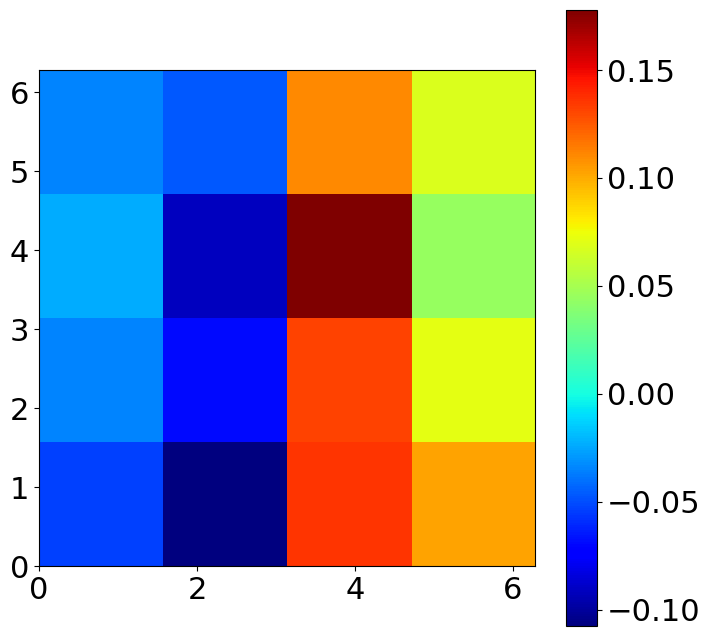

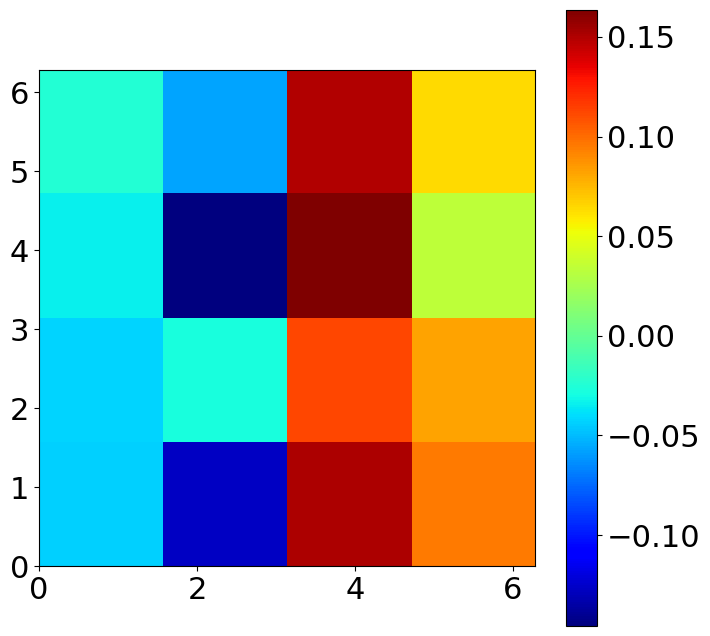

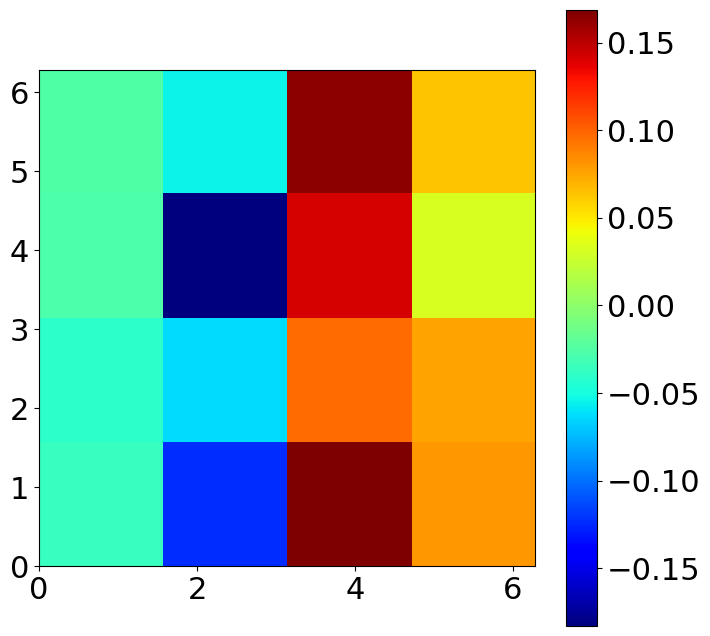

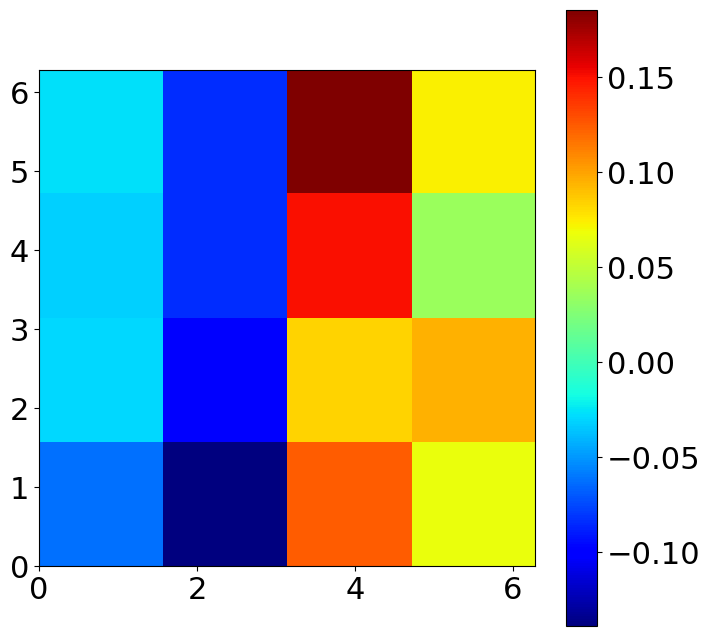

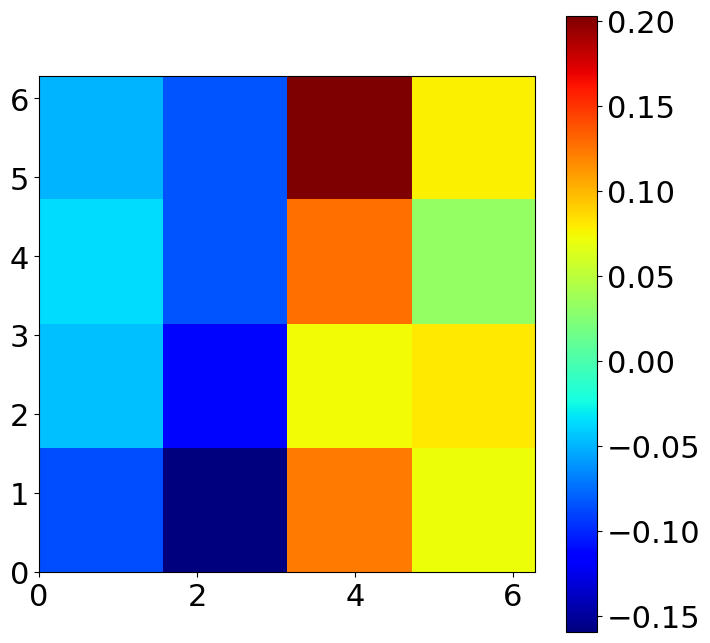

In [73]:
# initial parameters
TPer = 2*np.pi / 2**depth # roughly long enough to jump between boxes
NTrials = 20*N**2
gamma = .5**TPer

# initial training routine
for trial in range(NTrials):
    if trial % 10:
        print('{:4.1f}'.format(trial/NTrials*100)+'%\r',end='')
    alpha = .5/(trial/N**2 + 1)**(2/3) # scale by period
    tau = 1/3*np.log(trial/N**2+1)
    
    # initial parameters
    d = 5
    th_p = np.random.random()*2*np.pi
    th_e = np.random.random()*2*np.pi
    
    # loop through trajectories
    for i in range(int(Tmax/TPer)):
        # initial values
        node_init = Q_tree.node_from_coord(th_p,th_e)
        Q0 = node_init.values
        p = p_from_Q(Q0,tau)
        
        # random strategy from Q
        csum = np.cumsum(p)
        a = csum.searchsorted(np.random.random())
        up = lambda t,r1,r2,x1,x2: (a-1)*umax
        
        # update coordinates
        t,rp,re,th_pnew,th_enew = Chase(up,ue,umax=umax,
                                        rp0=np.array([-d,0]),th_p0=th_p,th_e0=th_e,
                                        T=TPer,dt=dt,eps=eps)
        
        # recenter to re = 0
        rp = rp[-1]-re[-1]
        d_new = np.linalg.norm(rp) # new distance
        # captured start again...
        if d_new < eps:
            continue
        
        # move predator to negative x axis
        dth = np.pi - np.arctan2(rp[1],rp[0])
        # update to new angles
        th_p = (th_pnew[-1] + dth) % (2*np.pi)
        th_e = (th_enew[-1] + dth) % (2*np.pi)
        node_final = Q_tree.node_from_coord(th_p,th_e)
        
        # update Q
        # reward d-d_new = reduced distance
        node_init.values[a] += alpha*((d-d_new)+gamma*max(node_final.values)-Q0[a])
        
    if trial % N**2 == 0:
        Q_tree.draw(depth,tau=tau)
        plt.colorbar()
        plt.show()
        # plt.savefig('init_train.pdf')

In [65]:
tau

6.08308361917057

In [74]:
for i in range(N):
    for j in range(N):
        x = 2**(-depth-1) + i*2**(-depth)
        y = 2**(-depth-1) + j*2**(-depth)
        Q_tree.refine(x,y,width=1,depth=2)
depth = 4

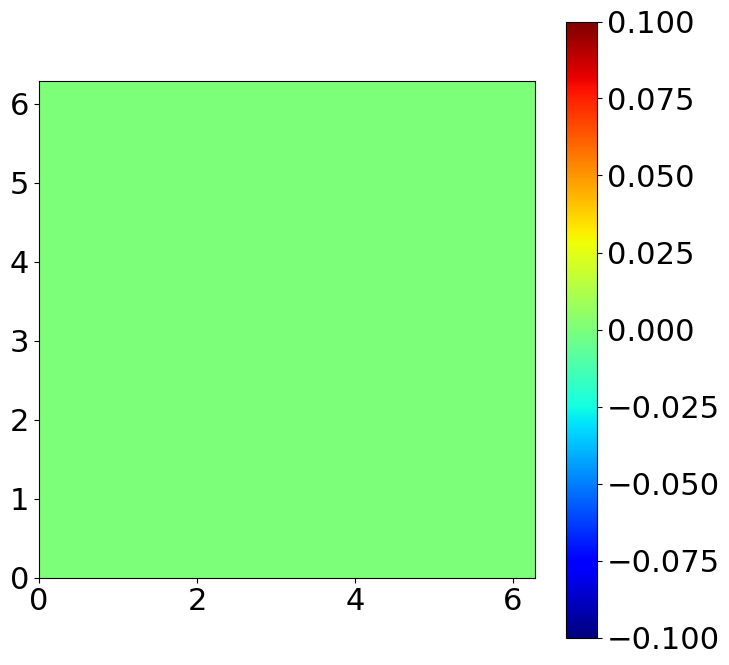

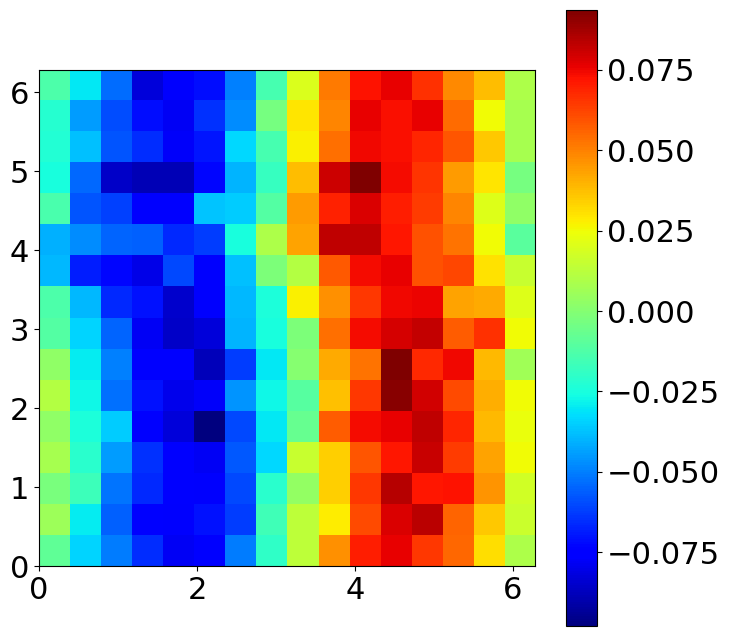

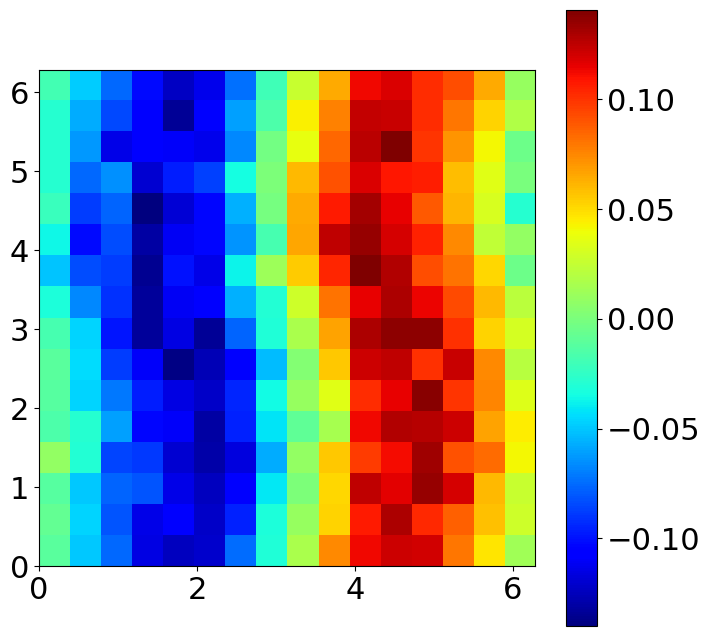

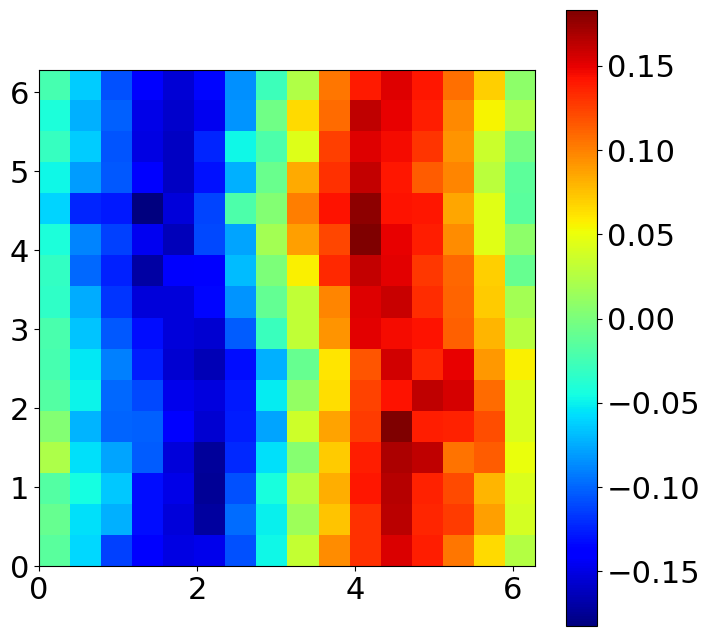

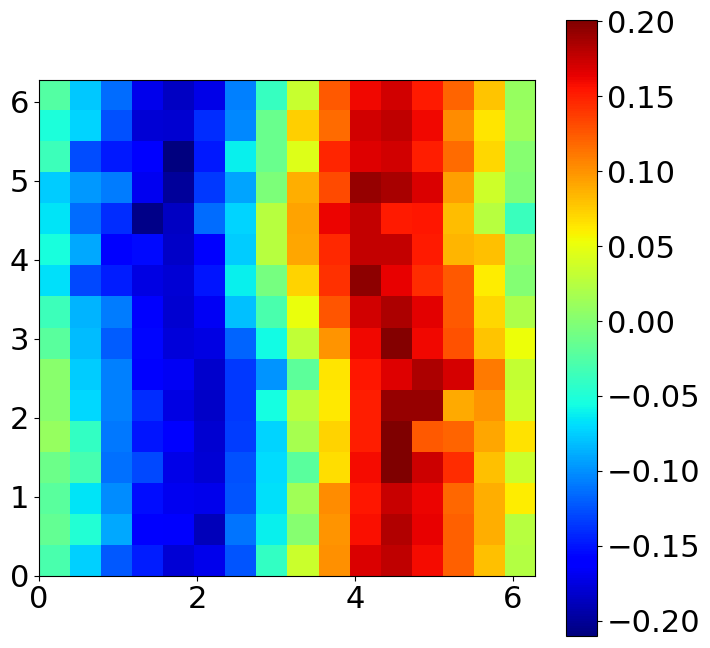

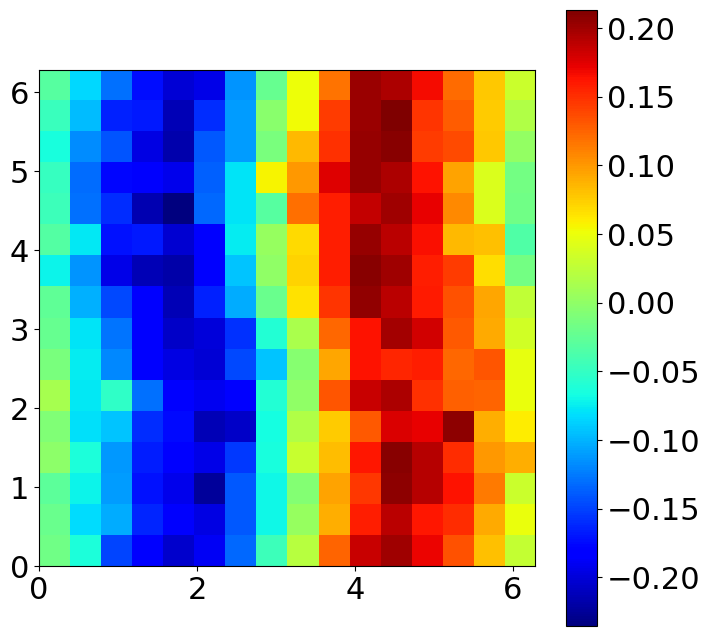

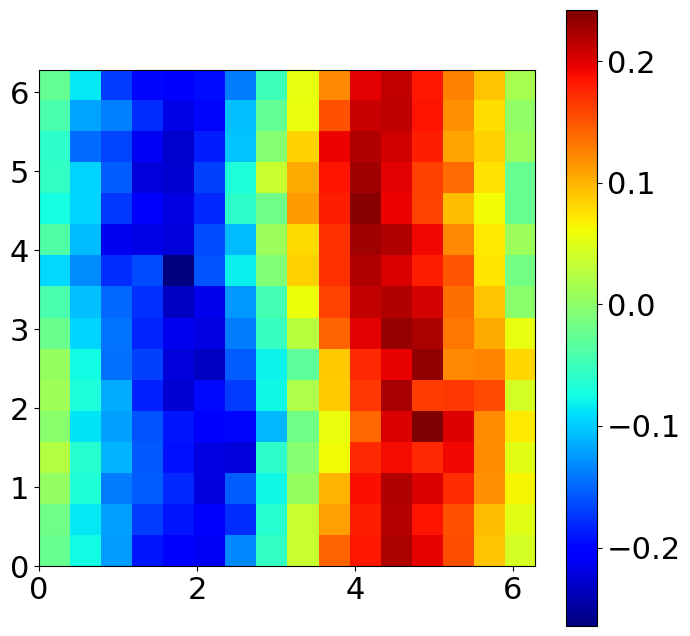

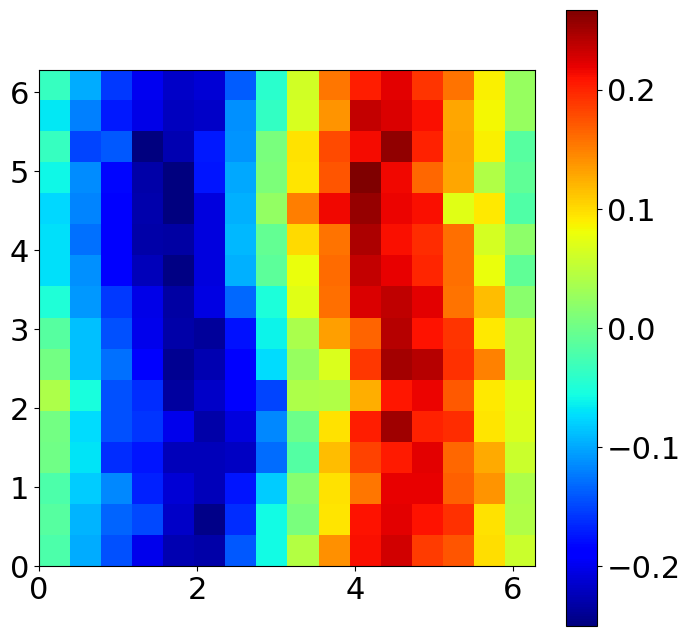

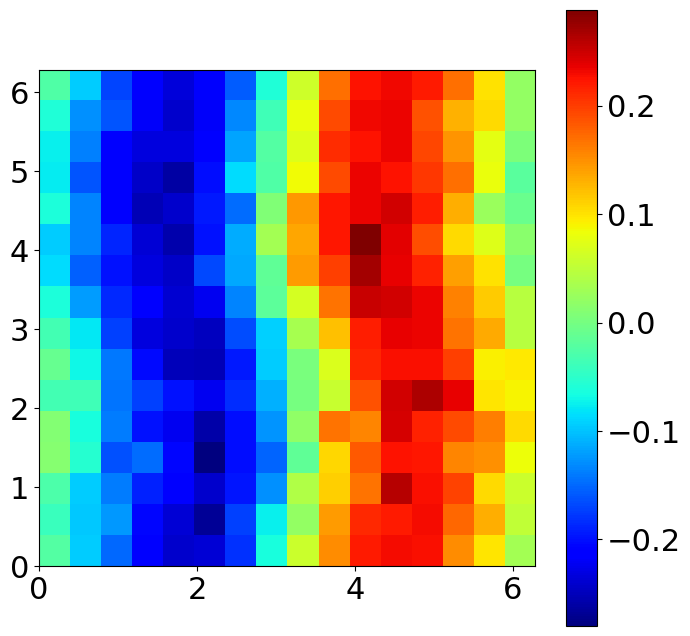

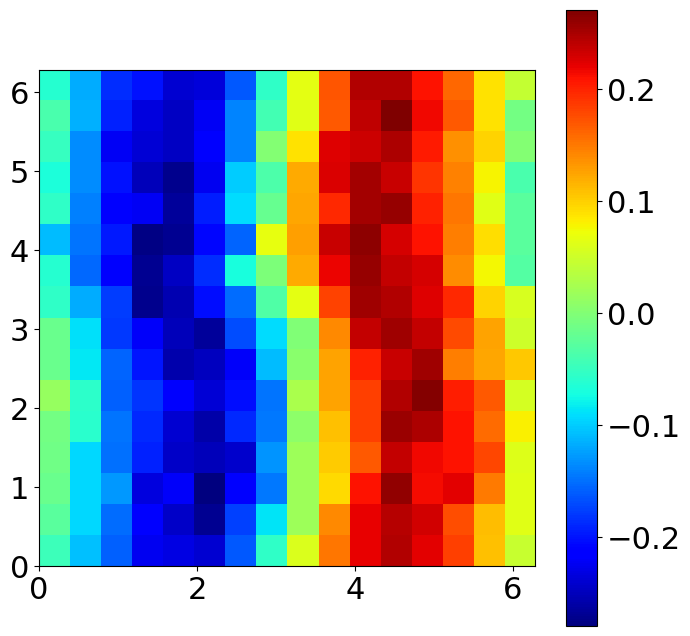

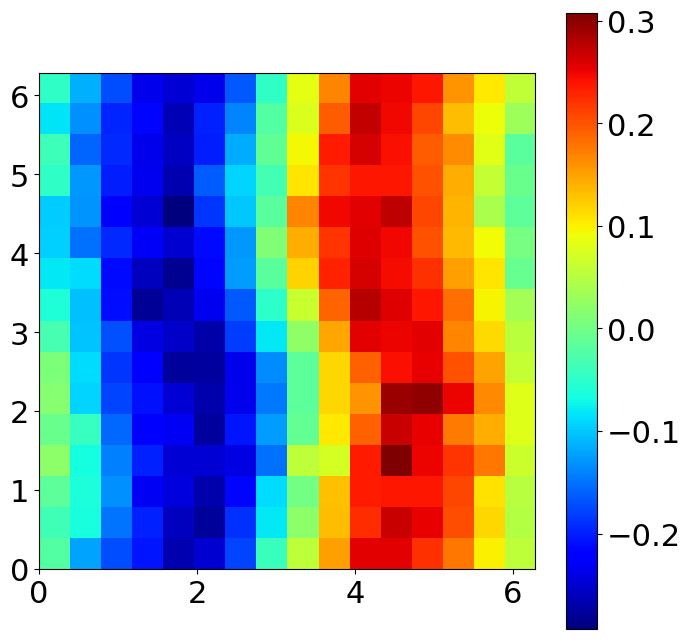

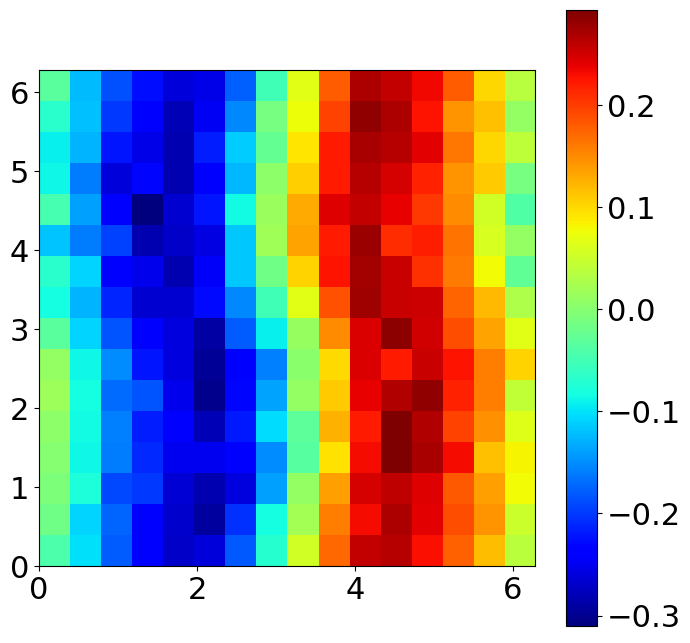

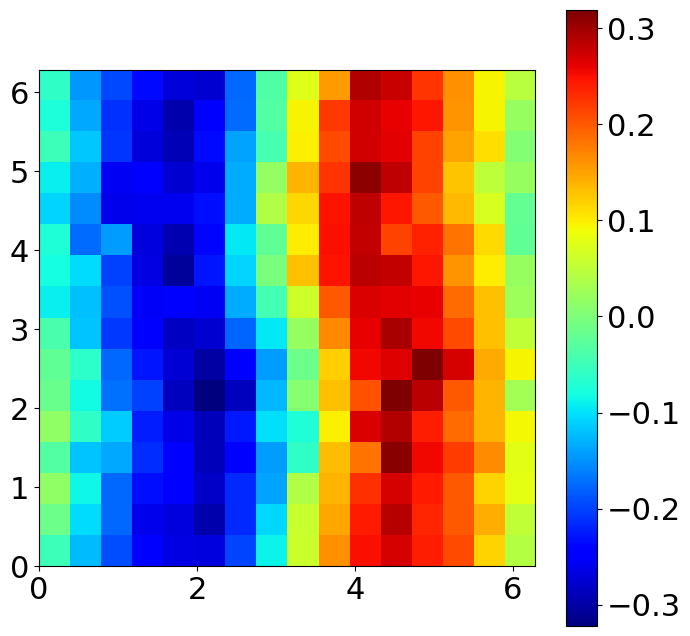

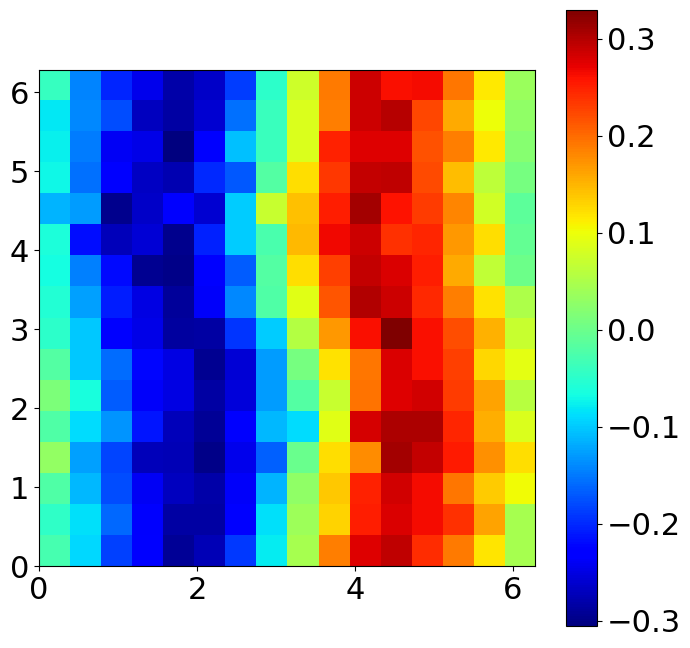

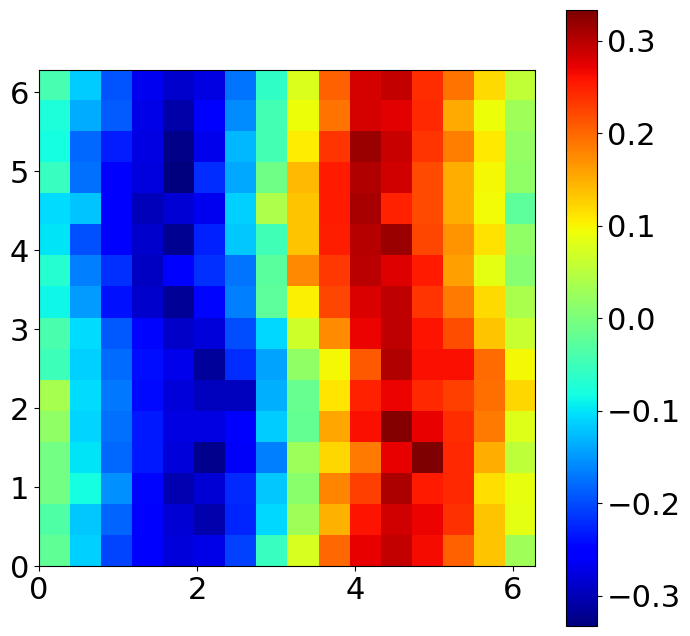

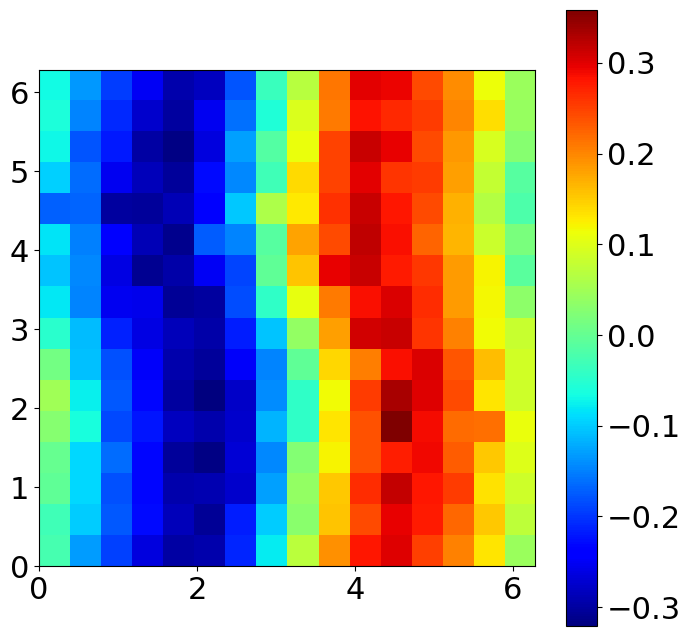

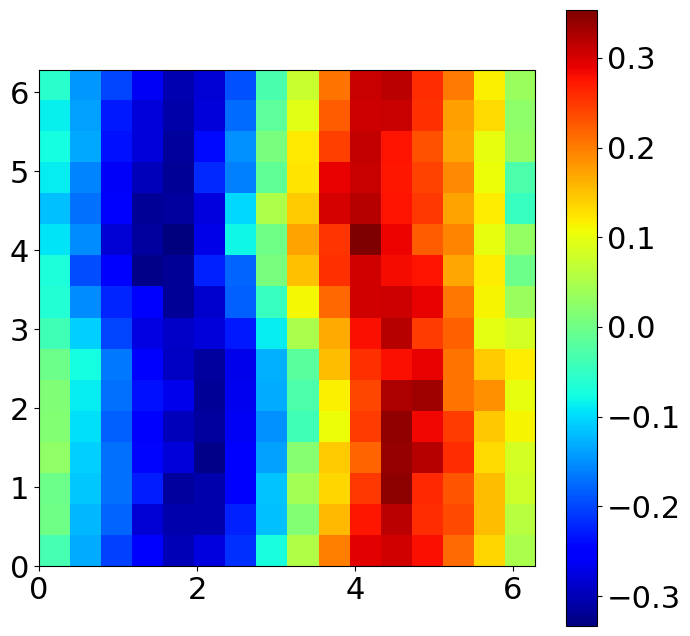

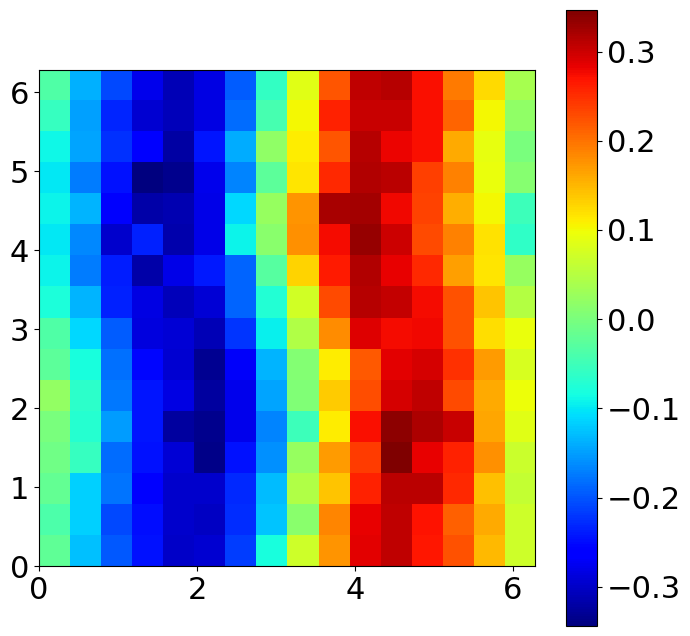

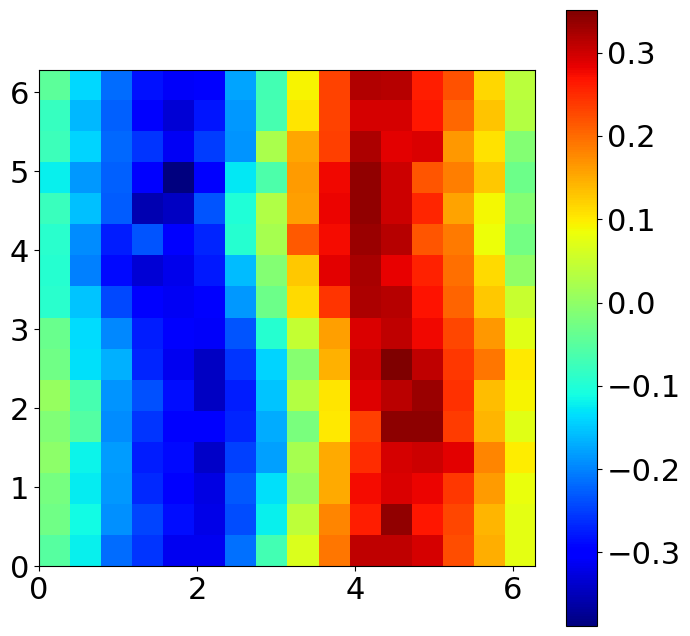

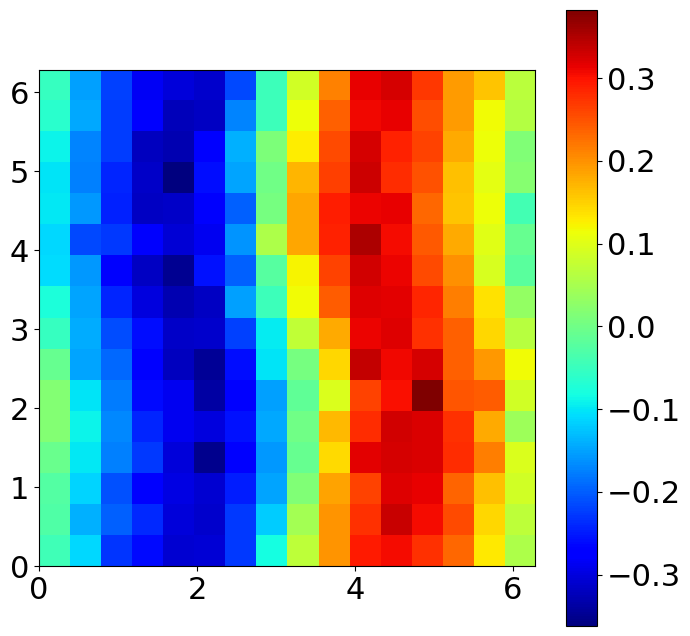

In [78]:
# initial parameters
N = 2**depth
TPer = 2*np.pi / 2**depth # roughly long enough to jump between boxes
NTrials = 20*(2**depth)**2
gamma = .5**TPer

# initial training routine
for trial in range(NTrials):
    if trial % 10:
        print('{:4.1f}'.format(trial/NTrials*100)+'%\r',end='')
    alpha = .5/(trial/10/N**2 + 1)**(2/3) # scale by period
    tau = 1/3*np.log(trial/N**2+1)
    
    # initial parameters
    d = 5
    th_p = np.random.random()*2*np.pi
    th_e = np.random.random()*2*np.pi
    
    # loop through trajectories
    for i in range(int(Tmax/TPer)):
        # initial values
        node_init = Q_tree.node_from_coord(th_p,th_e)
        Q0 = node_init.values
        p = p_from_Q(Q0,tau)
        
        # random strategy from Q
        csum = np.cumsum(p)
        a = csum.searchsorted(np.random.random())
        up = lambda t,r1,r2,x1,x2: (a-1)*umax
        
        # update coordinates
        t,rp,re,th_pnew,th_enew = Chase(up,ue,umax=umax,
                                        rp0=np.array([-d,0]),th_p0=th_p,th_e0=th_e,
                                        T=TPer,dt=dt,eps=eps)
        
        # recenter to re = 0
        rp = rp[-1]-re[-1]
        d_new = np.linalg.norm(rp) # new distance
        # captured start again...
        if d_new < eps:
            continue
        
        # move predator to negative x axis
        dth = np.pi - np.arctan2(rp[1],rp[0])
        # update to new angles
        th_p = (th_pnew[-1] + dth) % (2*np.pi)
        th_e = (th_enew[-1] + dth) % (2*np.pi)
        node_final = Q_tree.node_from_coord(th_p,th_e)
        
        # update Q
        # reward d-d_new = reduced distance
        node_init.values[a] += alpha*((d-d_new)+gamma*max(node_final.values)-Q0[a])
        
    if trial % (2**depth)**2 == 0:
        Q_tree.draw(depth,tau=tau)
        plt.colorbar()
        plt.show()
        # plt.savefig('init_train.pdf')

In [79]:
for i in range(N):
    for j in range(N):
        x = 2**(-depth-1) + i*2**(-depth)
        y = 2**(-depth-1) + j*2**(-depth)
        Q_tree.refine(x,y,width=1,depth=2)
depth = 6
N = 2**depth

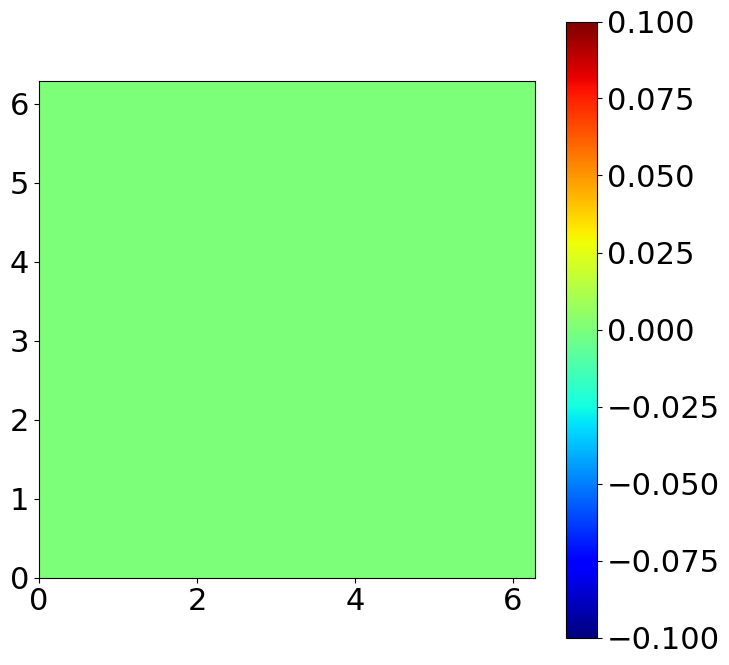

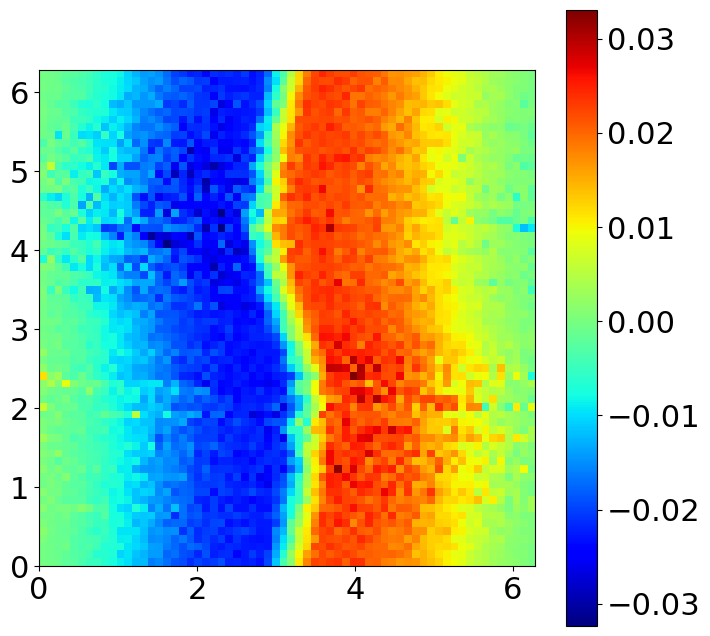

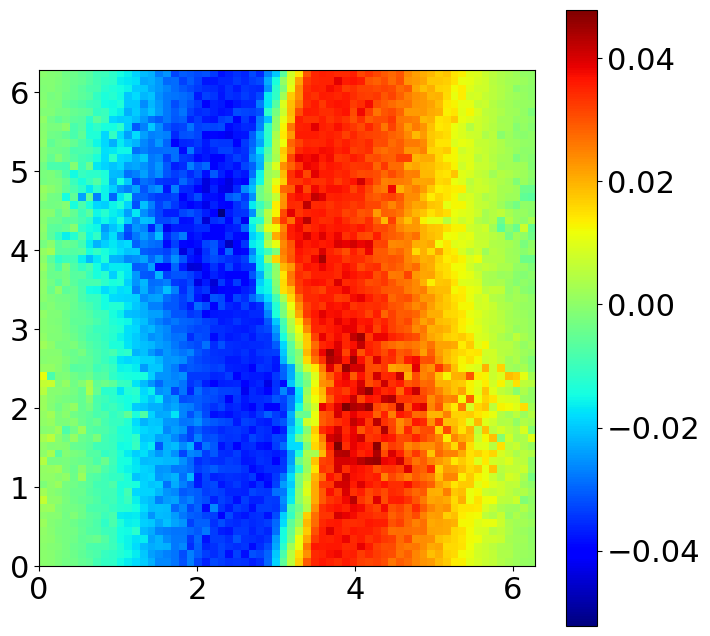

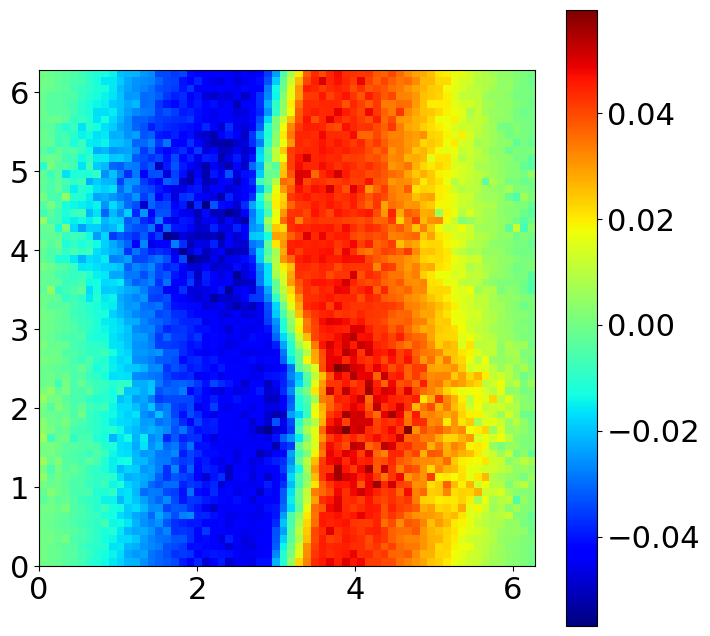

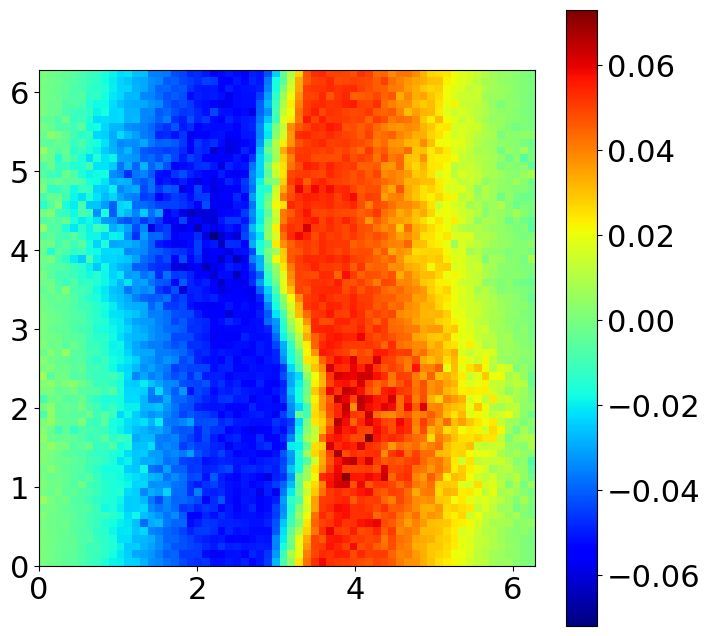

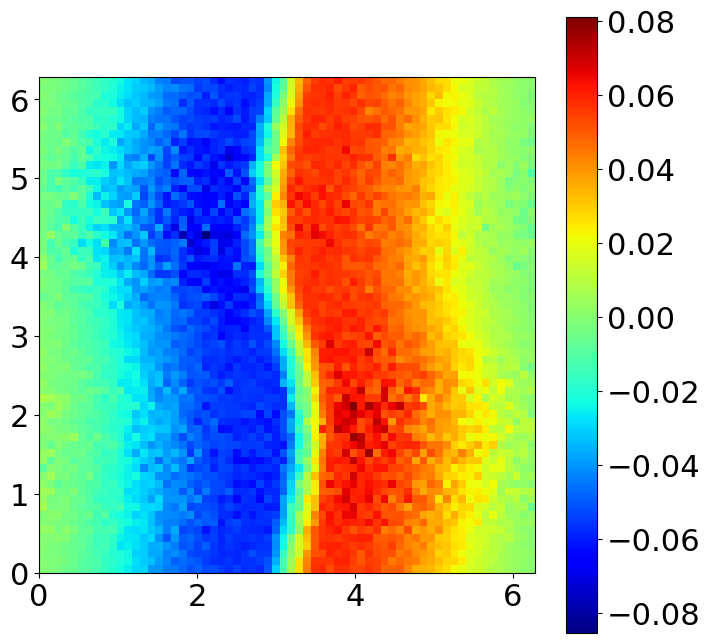

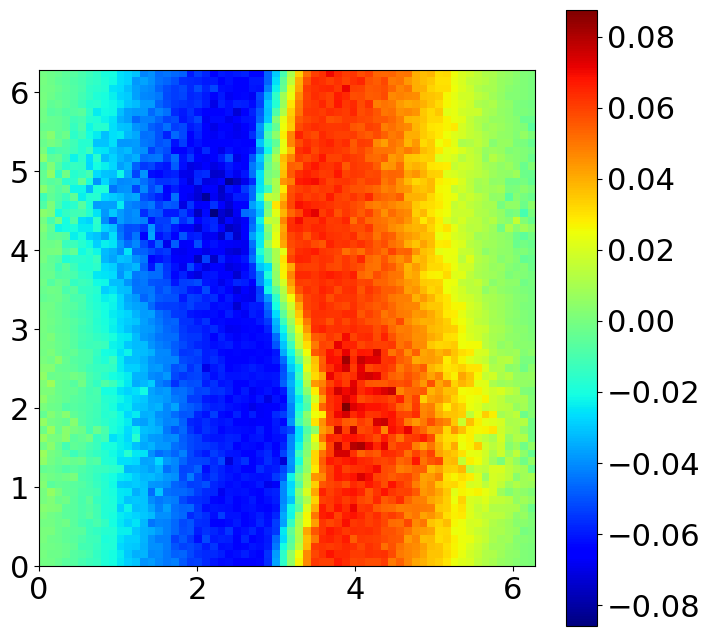

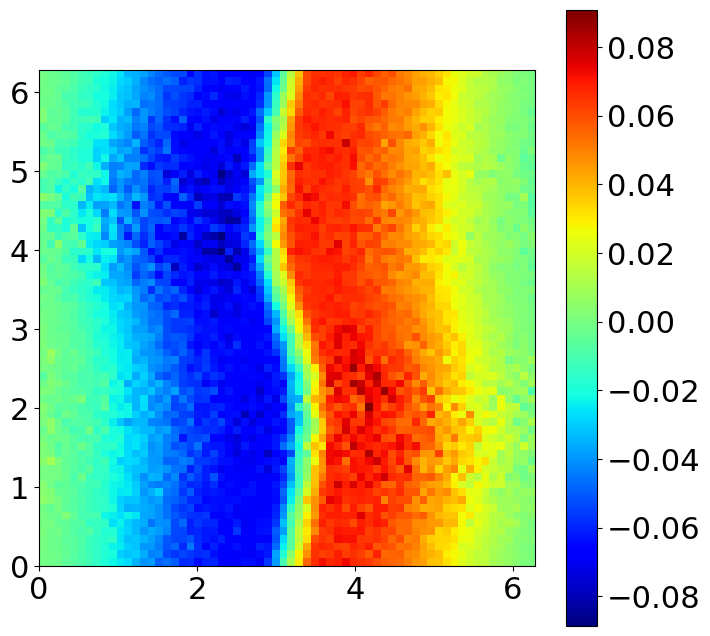

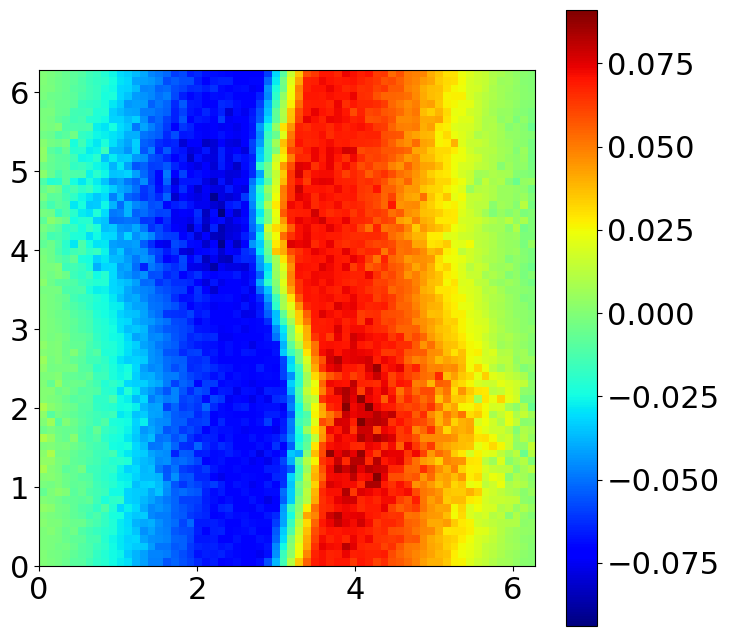

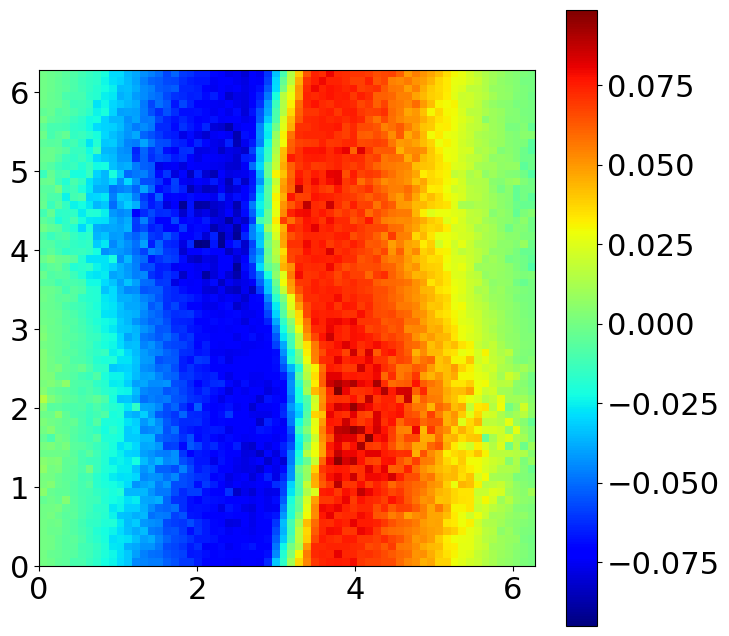

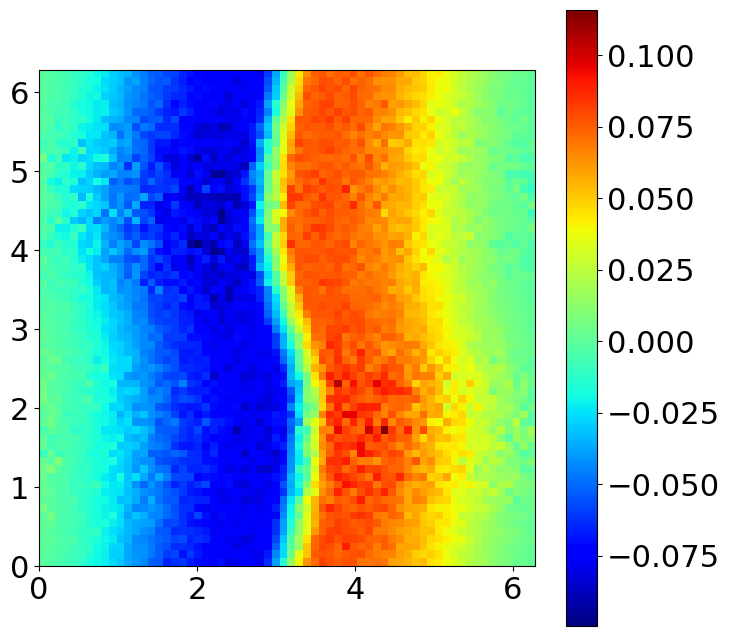

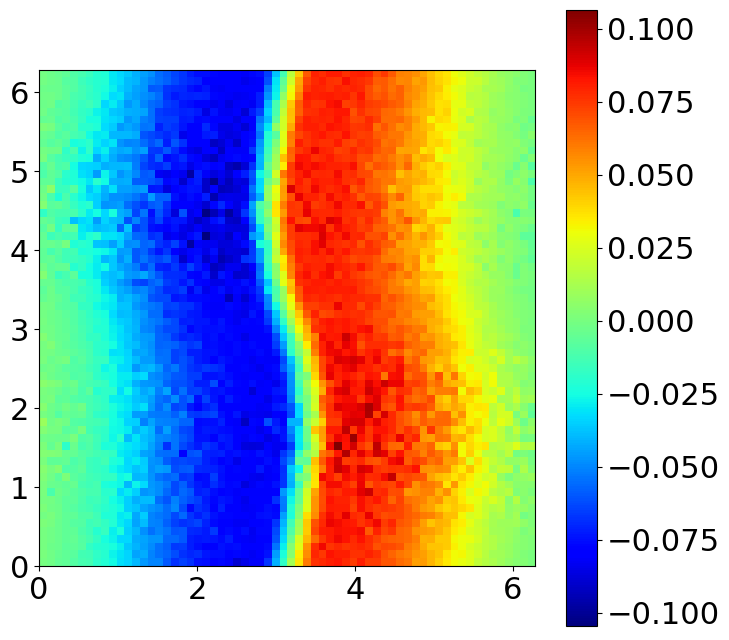

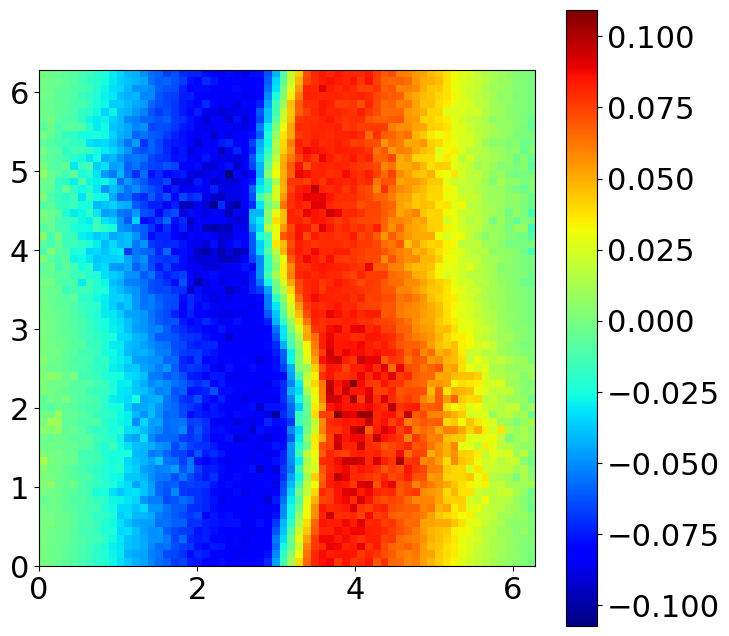

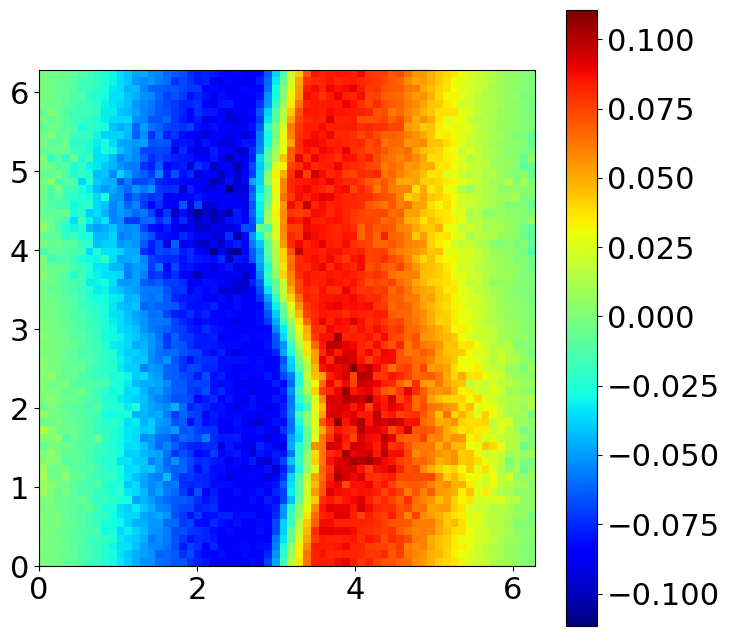

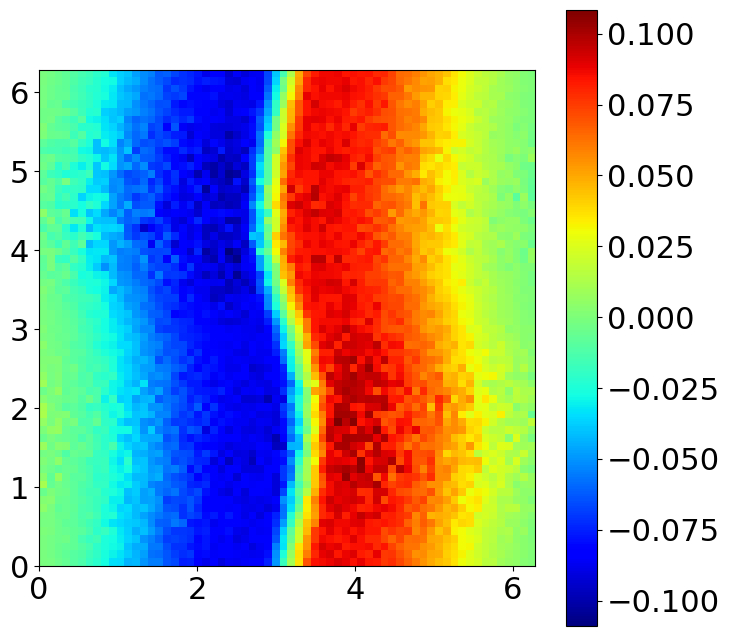

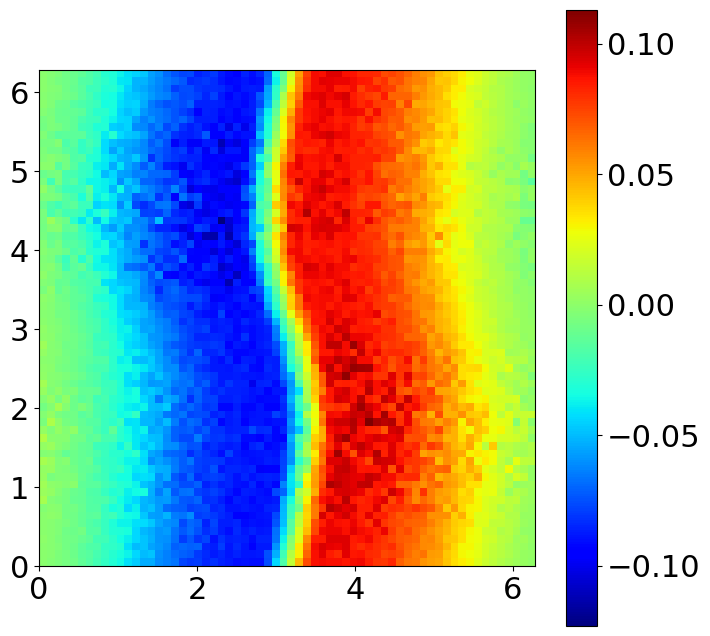

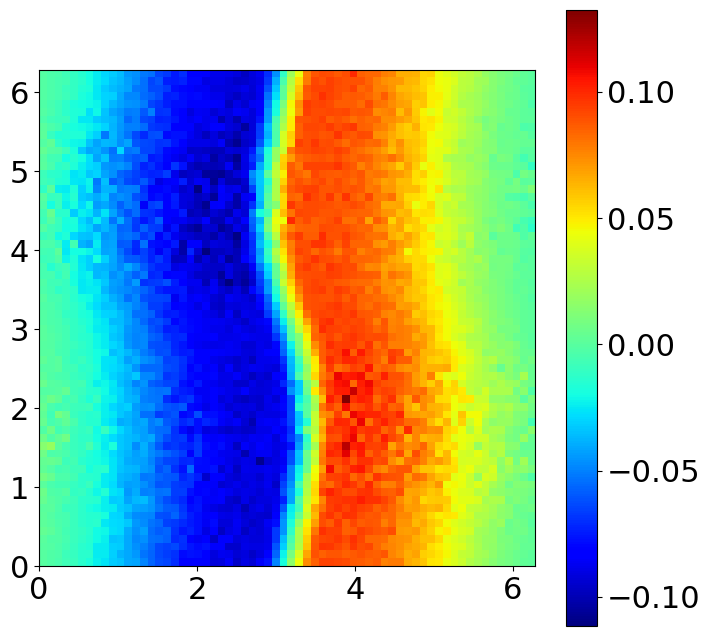

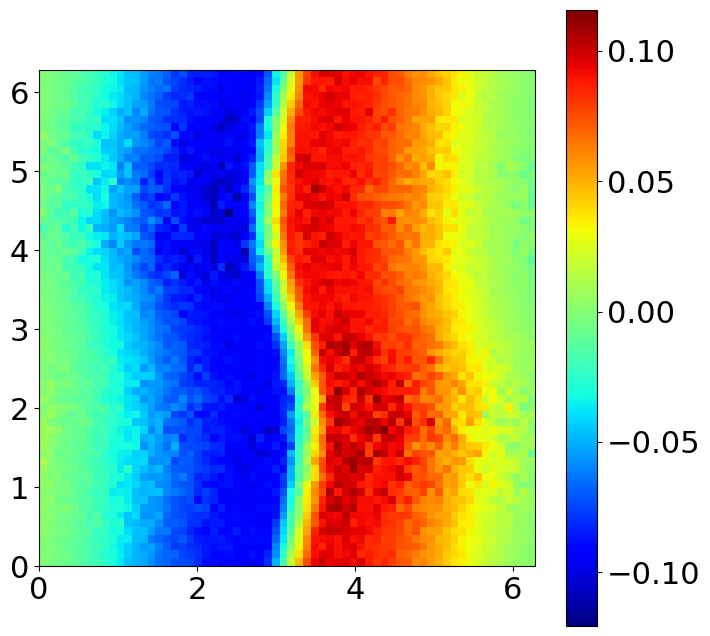

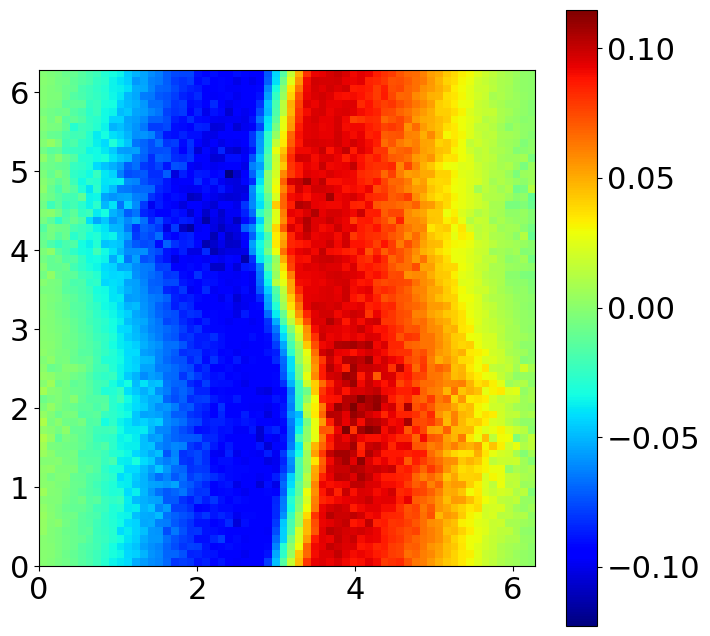

KeyboardInterrupt: 

In [80]:
# initial parameters
N = 2**depth
TPer = 2*np.pi / 2**depth # roughly long enough to jump between boxes
NTrials = 20*(2**depth)**2
gamma = .5**TPer

# initial training routine
for trial in range(NTrials):
    if trial % 10:
        print('{:4.1f}'.format(trial/NTrials*100)+'%\r',end='')
    alpha = .5/(trial/10/N**2 + 1)**(2/3) # scale by period
    tau = 1/3*np.log(trial/N**2+1)
    
    # initial parameters
    d = 5
    th_p = np.random.random()*2*np.pi
    th_e = np.random.random()*2*np.pi
    
    # loop through trajectories
    for i in range(int(Tmax/TPer)):
        # initial values
        node_init = Q_tree.node_from_coord(th_p,th_e)
        Q0 = node_init.values
        p = p_from_Q(Q0,tau)
        
        # random strategy from Q
        csum = np.cumsum(p)
        a = csum.searchsorted(np.random.random())
        up = lambda t,r1,r2,x1,x2: (a-1)*umax
        
        # update coordinates
        t,rp,re,th_pnew,th_enew = Chase(up,ue,umax=umax,
                                        rp0=np.array([-d,0]),th_p0=th_p,th_e0=th_e,
                                        T=TPer,dt=dt,eps=eps)
        
        # recenter to re = 0
        rp = rp[-1]-re[-1]
        d_new = np.linalg.norm(rp) # new distance
        # captured start again...
        if d_new < eps:
            continue
        
        # move predator to negative x axis
        dth = np.pi - np.arctan2(rp[1],rp[0])
        # update to new angles
        th_p = (th_pnew[-1] + dth) % (2*np.pi)
        th_e = (th_enew[-1] + dth) % (2*np.pi)
        node_final = Q_tree.node_from_coord(th_p,th_e)
        
        # update Q
        # reward d-d_new = reduced distance
        node_init.values[a] += alpha*((d-d_new)+gamma*max(node_final.values)-Q0[a])
        
    if trial % (2**depth)**2 == 0:
        Q_tree.draw(depth,tau=tau)
        plt.colorbar()
        plt.show()
        # plt.savefig('init_train.pdf')

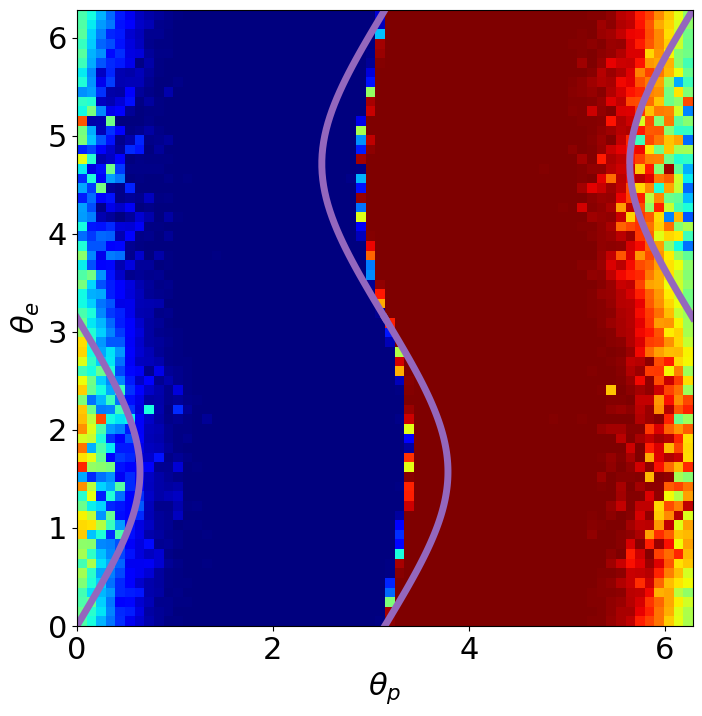

In [88]:
# save figure
Q_tree.draw(depth,tau=100)
y_data = np.linspace(0,np.pi,100)
plt.plot(np.arcsin(0.6*np.sin(y_data)) % (2*np.pi), y_data, 'C4', linewidth=5)
plt.plot((np.arcsin(0.6*np.sin(y_data))+np.pi) % (2*np.pi), y_data, 'C4', linewidth=5)

y_data = np.linspace(np.pi+1e-14,2*np.pi,50)
plt.plot(np.arcsin(0.6*np.sin(y_data)) % (2*np.pi), y_data, 'C4', linewidth=5)
plt.plot((np.arcsin(0.6*np.sin(y_data))+np.pi) % (2*np.pi), y_data, 'C4', linewidth=5)

plt.xlabel(r'$\theta_p$')
plt.ylabel(r'$\theta_e$')
plt.savefig('state_mat_learn.pdf')

In [297]:
###############################
#### Refine along main contour
###############################
y_data = np.array([2*np.pi*(2**(-depth-1) + i*2**(-depth)) for i in range(2**depth)])
x_data = np.arcsin(0.6*np.sin(y_data)) % (2*np.pi)

for i,y in enumerate(y_data):
    x = x_data[i]
    Q_tree.refine(x,y,depth=2)
    x = (x_data[i] + 2**(-depth)*2*np.pi) % (2*np.pi)
    Q_tree.refine(x,y,depth=2)
    x = (x_data[i] - 2**(-depth)*2*np.pi) % (2*np.pi)
    Q_tree.refine(x,y,depth=2)
    
    x = (x_data[i]+np.pi) % (2*np.pi)
    Q_tree.refine(x,y,depth=2)
    x = (x_data[i] + 2**(-depth)*2*np.pi+np.pi) % (2*np.pi)
    Q_tree.refine(x,y,depth=2)
    x = (x_data[i] - 2**(-depth)*2*np.pi+np.pi) % (2*np.pi)
    Q_tree.refine(x,y,depth=2)

In [ ]:
###############################
#### Train refined mesh
# reduce period of sampling for finer mesh
TPer = 2*np.pi / 3 / 4
gamma = .5**TPer
# focus new areas
Temp = 2

# initial training routine
for trial in range(NTrials,3*NTrials):
    if trial % 10:
        print('{:4.1f}'.format((trial-NTrials)/2/NTrials*100)+'%\r',end='')
    alpha = 1/(trial/N**2+1) # scale by period
    
    # initial parameters
    d = 5
    th_p = np.random.random()*2*np.pi
    th_e = np.random.random()*2*np.pi
    
    # loop through trajectories
    for i in range(int(Tmax/TPer)):
        # initial values
        node_init = Q_tree.node_from_coord(th_p,th_e)
        Q0 = node_init.values
        p = p_from_Q(Q0,Temp)
        
        # random strategy from Q
        csum = np.cumsum(p)
        a = csum.searchsorted(np.random.random())
        up = lambda t,r1,r2,x1,x2: (a-1)*umax
        
        # update coordinates
        t,rp,re,th_pnew,th_enew = Chase(up,ue,umax=umax,
                                        rp0=np.array([-d,0]),th_p0=th_p,th_e0=th_e,
                                        T=TPer,dt=dt,eps=eps)
        
        # recenter to re = 0
        rp = rp[-1]-re[-1]
        d_new = np.linalg.norm(rp) # new distance
        # captured start again...
        if d_new < eps:
            continue
        
        # move predator to negative x axis
        dth = np.pi - np.arctan2(rp[1],rp[0])
        # update to new angles
        th_p = (th_pnew[-1] + dth) % (2*np.pi)
        th_e = (th_enew[-1] + dth) % (2*np.pi)
        node_final = Q_tree.node_from_coord(th_p,th_e)
        
        # update Q
        # reward d-d_new = reduced distance
        node_init.values[a] += alpha*((d-d_new)+gamma*max(node_final.values)-Q0[a])
        
Q_tree.draw(6)
plt.colorbar()
plt.show()

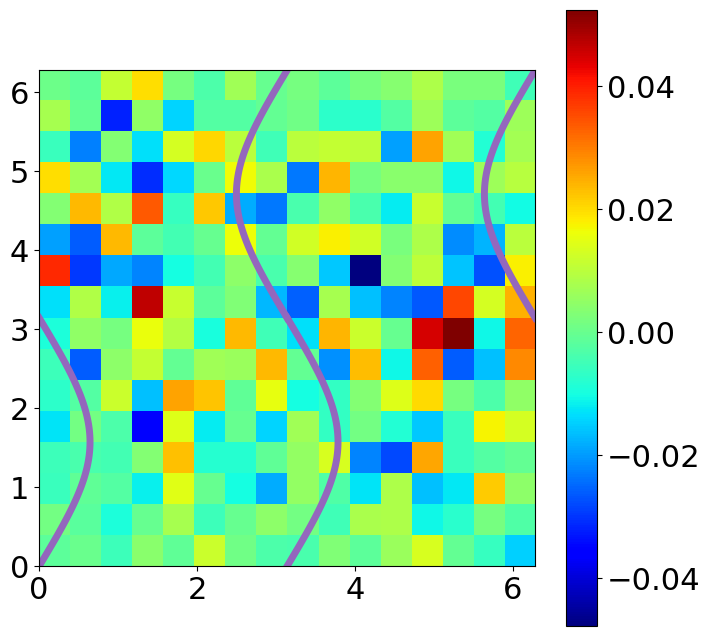

In [298]:
# Q_tree.draw(4)
Temp = 1
def draw(tree,depth = 6):
    plt.subplots(figsize=(8,8))
    depth = int(depth) # got make sure
    N = 2**depth
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            # center of box of given depth
            x = 2**(-depth-1) + i*2**(-depth)
            y = 2**(-depth-1) + j*2**(-depth)
            Q = tree.node_from_coord(x,y,width=1).values
#             print(Q)
            p = p_from_Q(Q,Temp)
            M[i,j] = p @ np.arange(-1,2)
#             print(p[1])
#             print(M[i,j])
    plt.imshow(M.T,cmap='jet',origin='lower',extent=[0,2*np.pi,0,2*np.pi])
    
# Q_tree.node_from_coord(.1,.1,width=1).values = np.arange(3)
    
draw(Q_tree,6)
plt.colorbar()
# X,Y = np.meshgrid(np.linspace(0,2*np.pi,100),np.linspace(0,2*np.pi,100))
# plt.contour(X,Y,0.6*np.sin(Y)-np.sin(X),[-1,0,1])

Q_tree.node_from_coord(1/3,1/3).values
y_data = np.linspace(0,np.pi,100)
plt.plot(np.arcsin(0.6*np.sin(y_data)) % (2*np.pi), y_data, 'C4', linewidth=5)
plt.plot((np.arcsin(0.6*np.sin(y_data))+np.pi) % (2*np.pi), y_data, 'C4', linewidth=5)

y_data = np.linspace(np.pi+1e-14,2*np.pi,100)
plt.plot(np.arcsin(0.6*np.sin(y_data)) % (2*np.pi), y_data, 'C4', linewidth=5)
plt.plot((np.arcsin(0.6*np.sin(y_data))+np.pi) % (2*np.pi), y_data, 'C4', linewidth=5)

# y_data = np.array([2*np.pi*(2**(-depth-1) + i*2**(-depth)) for i in range(2**depth)])
# plt.scatter(np.zeros_like(y_data),y_data,marker='x',s=200)

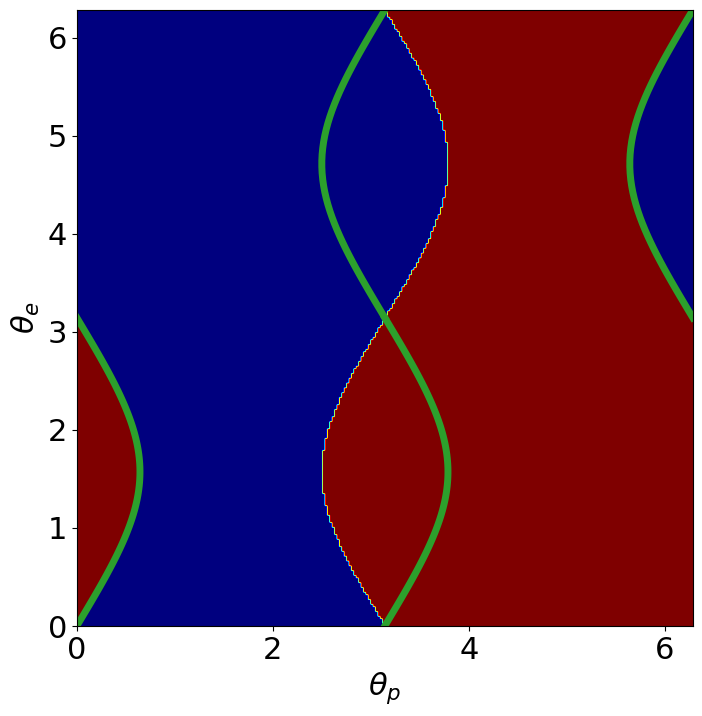

In [92]:
def sign(x):
    if x==0:
        return 0
    elif x>0:
        return 1
    else:
        return -1

plt.subplots(figsize=(8,8))
depth = int(depth) # got make sure
res = 8
N = 2**res
M = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        th_p = (2**(-res-1) + i*2**(-res))*2*np.pi
        x_p = np.array([np.cos(th_p),np.sin(th_p)])
        th_e = (2**(-res-1) + j*2**(-res))*2*np.pi
        x_e = np.array([np.cos(th_e),np.sin(th_e)])
        
        M[i,j] = sign(uCATD()(0,np.array([-1,0]),np.zeros(2),x_p,x_e))
#             print(p[1])
#             print(M[i,j])
plt.imshow(M.T,cmap='jet',origin='lower',extent=[0,2*np.pi,0,2*np.pi])

y_data = np.linspace(0,np.pi,100)
plt.plot(np.arcsin(0.6*np.sin(y_data)) % (2*np.pi), y_data, 'C2', linewidth=5)
plt.plot((np.arcsin(0.6*np.sin(y_data))+np.pi) % (2*np.pi), y_data, 'C2', linewidth=5)

y_data = np.linspace(np.pi+1e-14,2*np.pi,50)
plt.plot(np.arcsin(0.6*np.sin(y_data)) % (2*np.pi), y_data, 'C2', linewidth=5)
plt.plot((np.arcsin(0.6*np.sin(y_data))+np.pi) % (2*np.pi), y_data, 'C2', linewidth=5)

plt.xlabel(r'$\theta_p$')
plt.ylabel(r'$\theta_e$')
plt.savefig('state_mat_CATD.pdf')